In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial import distance
import sys
import os

os.chdir("../../")
from pathlib import Path

sys.path.append("scripts/")

import my_utils
import distclassipy as dcpy

cd = dcpy.Distance()

In [2]:
sns.set_theme(
    context="paper",
    style="whitegrid",
    font_scale=1.5,
    rc={
        "xtick.bottom": True,
        "xtick.top": False,
        "ytick.left": True,
        "ytick.right": False,
        "axes.grid": False,
        "axes.edgecolor": ".15",
    },
)

In [3]:
ref_point = np.array([5, 5])  # reference point

In [4]:
x = np.linspace(0, 10, 100)
y = np.linspace(0, 10, 100)
X, Y = np.meshgrid(x, y)
points = np.vstack([X.ravel(), Y.ravel()]).T

In [5]:
metric = cd.add_chisq  # canberra
metric_str = my_utils.get_metric_name(metric)

In [6]:
distances = distance.cdist(ref_point.reshape(1, -1), points, metric=metric)
distances = distances.reshape(X.shape)

In [7]:
from matplotlib import ticker, cm

In [8]:
all_metrics = [
    "euclidean",
    "braycurtis",
    "canberra",
    "cityblock",
    "chebyshev",
    cd.clark,
    # "correlation",
    "cosine",
    cd.hellinger,
    cd.jaccard,
    cd.lorentzian,
    # cd.marylandbridge,
    cd.meehl,
    cd.motyka,
    cd.soergel,
    cd.wave_hedges,
    cd.kulczynski,
    cd.add_chisq,  # LOG ONES
]
print(len(all_metrics))

16


In [9]:
plt.rcParams["figure.dpi"] = 300

C:\Users\Meet\AppData\Local\Temp\ipykernel_128108\3781171980.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 2, 4, 6, 8, 10])
C:\Users\Meet\AppData\Local\Temp\ipykernel_128108\3781171980.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 2, 4, 6, 8, 10])
c:\Python312\Lib\site-packages\distclassipy\distances.py:602: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(u - v)) / np.sum(np.minimum(u, v))
C:\Users\Meet\AppData\Local\Temp\ipykernel_128108\3781171980.py:27: RuntimeWarning: divide by zero encountered in log10
  np.log10(distances),
C:\Users\Meet\AppData\Local\Temp\ipykernel_128108\3781171980.py:36: UserWarning: Log scale: values of z <= 0 have been masked
  cs = ax.contour(X, Y, distances, colors="k", locator=ticker.LogLocator())


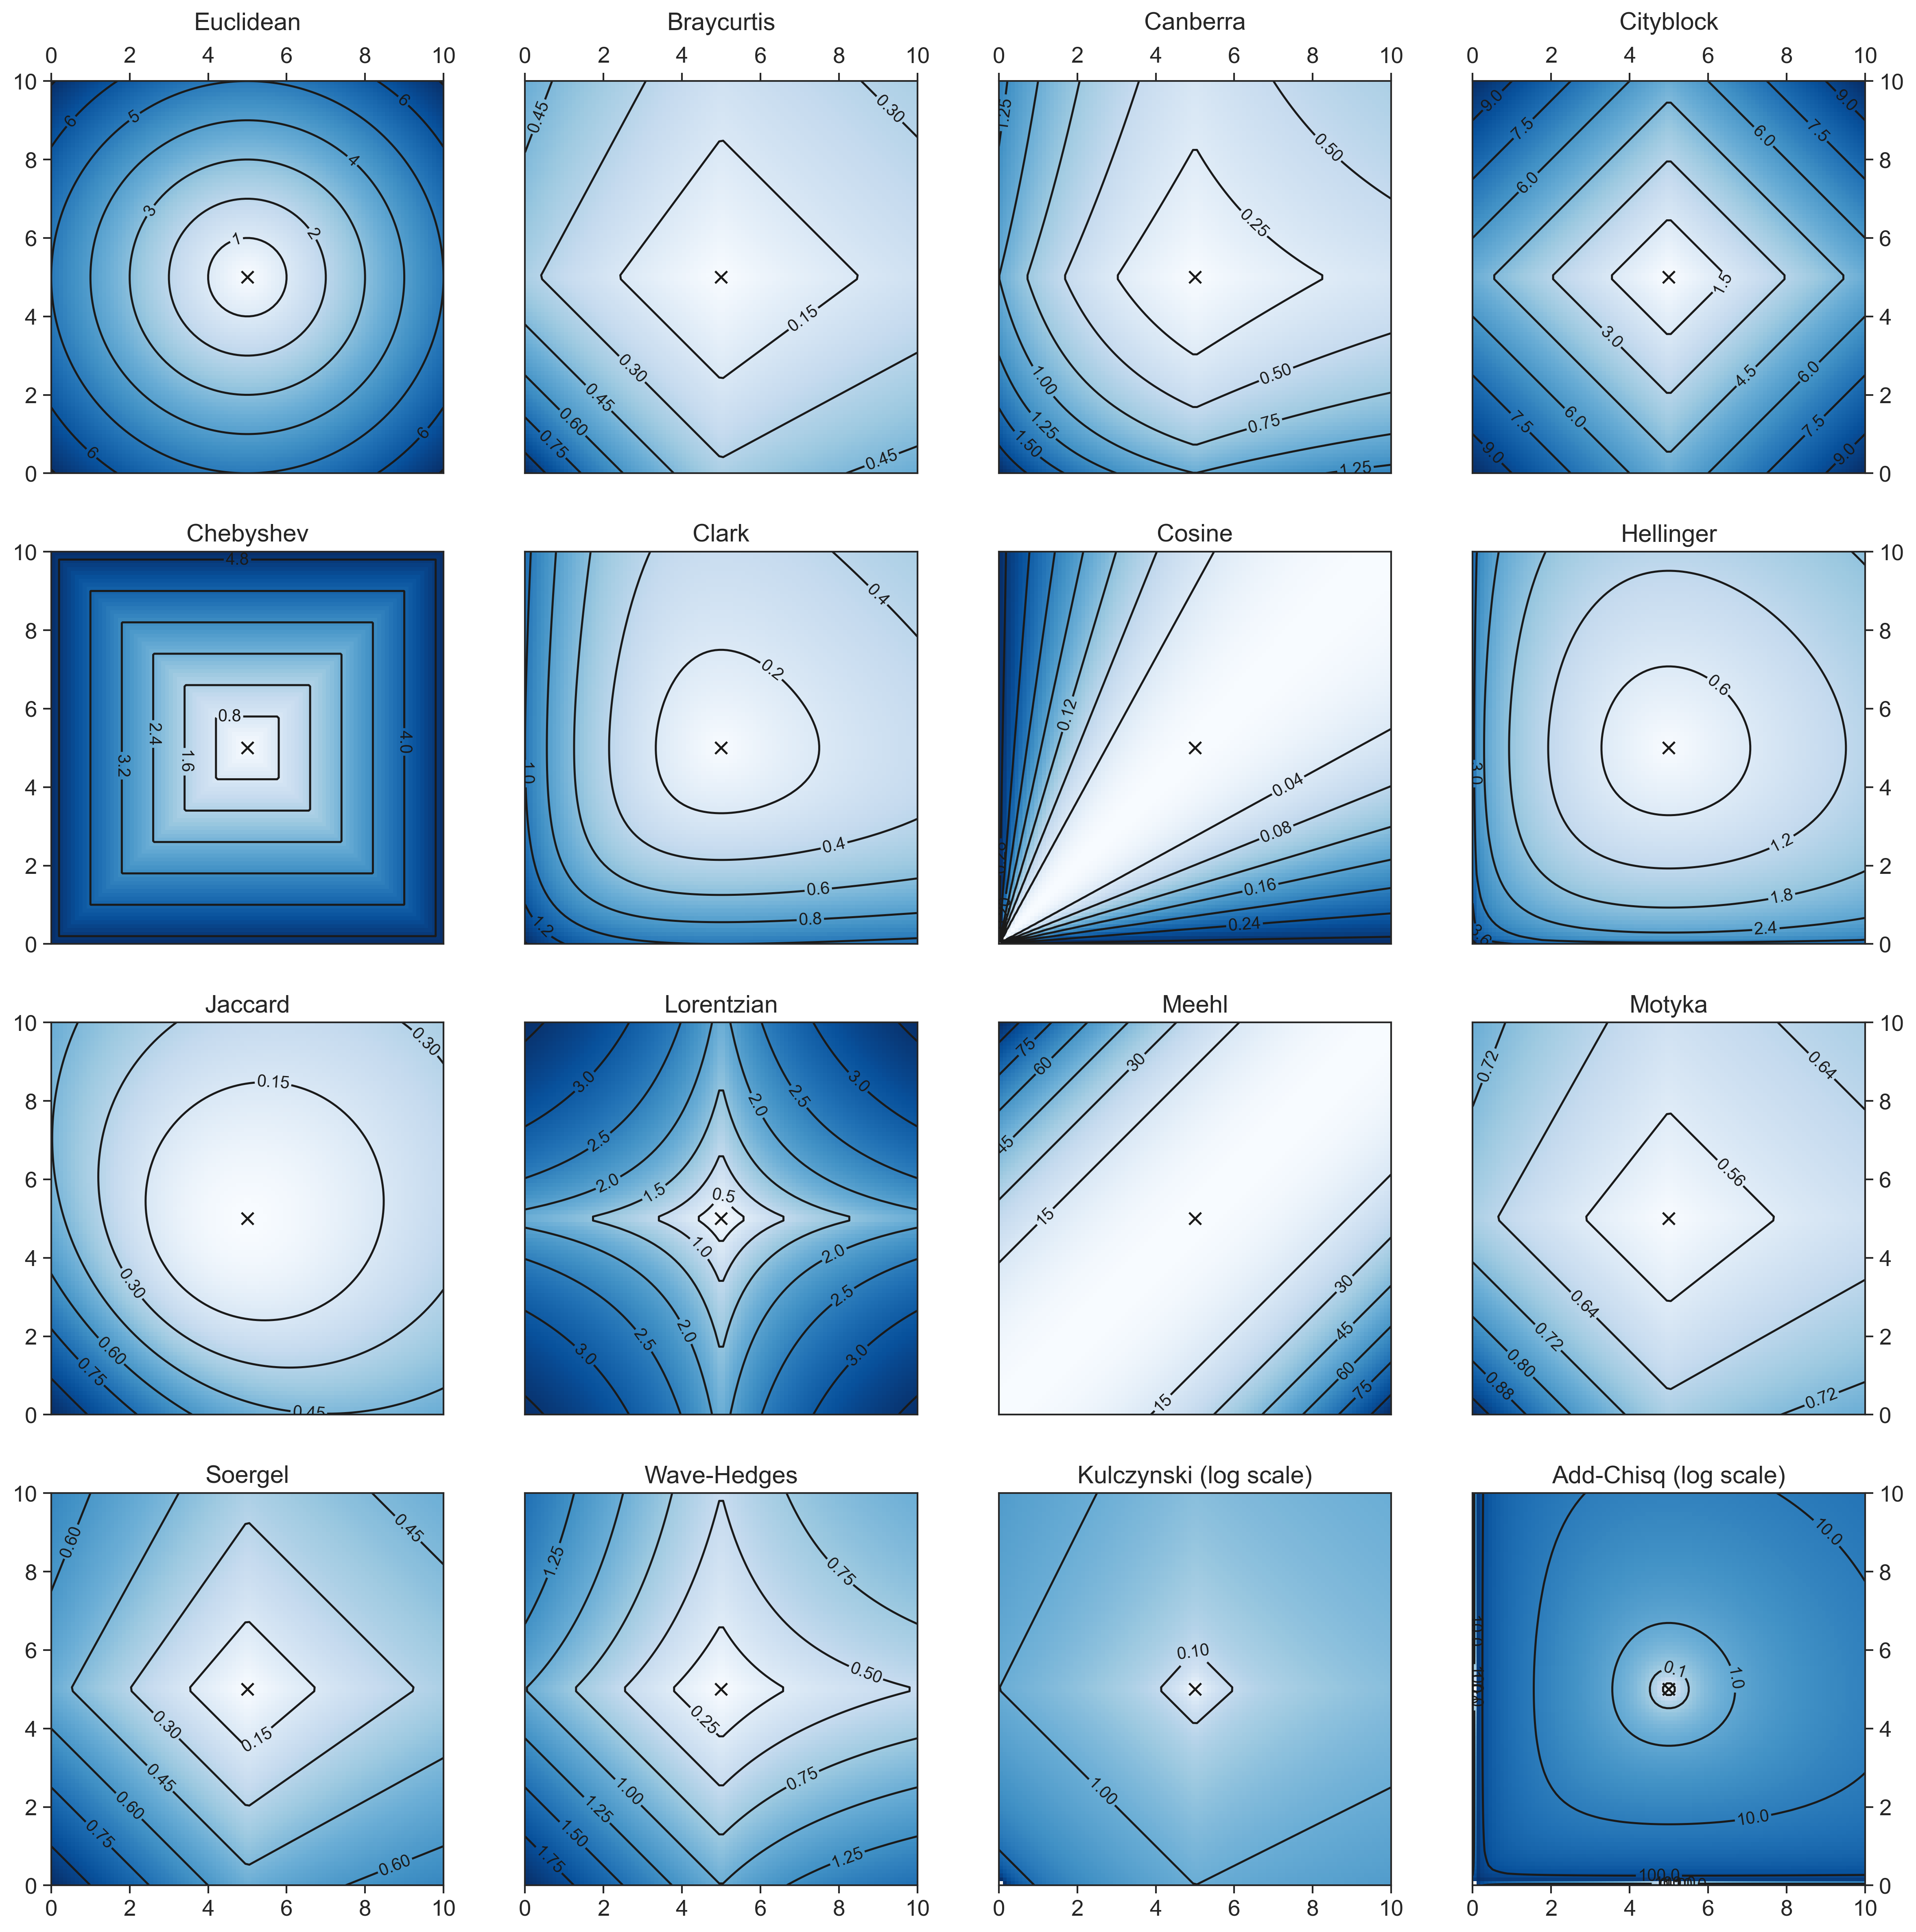

In [10]:
fig, axs = plt.subplots(4, 4, figsize=(19.2, 19.2), sharex=False, sharey=False)
for i, metricax in enumerate(zip(all_metrics, axs.ravel())):
    metric, ax = metricax
    metric_str = my_utils.get_metric_name(metric)
    distances = distance.cdist(ref_point.reshape(1, -1), points, metric=metric)
    distances = distances.reshape(X.shape)

    if metric_str not in ["Add_Chisq", "Kulczynski"]:
        # Make normal plot
        im = ax.imshow(
            distances,
            # cmap='viridis_r',
            cmap="Blues",
            interpolation="nearest",
            extent=[0, 10, 0, 10],
            origin="lower",
        )
        # cbar = fig.colorbar(im)
        ax.scatter(5, 5, s=50, color="k", marker="x")
        cs = ax.contour(X, Y, distances, colors="k")
        ax.clabel(cs, inline=True, fontsize=10, colors="k")
        ax.set_title(f"{metric_str.title().replace('_','-')}")

    else:
        # Make log plot
        im = ax.imshow(
            np.log10(distances),
            # cmap='viridis_r',
            cmap="Blues",
            interpolation="nearest",
            extent=[0, 10, 0, 10],
            origin="lower",
        )
        # cbar = fig.colorbar(im)
        ax.scatter(5, 5, s=50, color="k", marker="x")
        cs = ax.contour(X, Y, distances, colors="k", locator=ticker.LogLocator())
        ax.clabel(cs, inline=True, fontsize=10, colors="k")
        ax.set_title(f"{metric_str.title().replace('_','-')} (log scale)")

    if i % 4 == 0:
        ax.get_xaxis().set_visible(False)
    if i % 4 == 1 or i % 4 == 2:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    if i % 4 == 3:
        ax.set_yticklabels([0, 2, 4, 6, 8, 10])
        ax.get_xaxis().set_visible(False)
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")

    if i // 4 == 0:
        ax.get_xaxis().set_visible(True)
        ax.set_xticklabels([0, 2, 4, 6, 8, 10])
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position("top")
        ax.set_title(ax.get_title(), pad=10)

    if i // 4 == 4 - 1:
        ax.get_xaxis().set_visible(True)


# plt.suptitle(f"Distance from ({ref_point[0]}, {ref_point[1]})")
# fig.subplots_adjust(hspace=0.2, wspace=-0.5)
# plt.tight_layout()

Path("results").mkdir(parents=True, exist_ok=True)
plt.savefig(os.path.join("results", "distances_viz.pdf"), bbox_inches="tight")
plt.show()

In [12]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial import distance
from networkx.algorithms.community import louvain_communities
from networkx.algorithms.coloring import greedy_color

# Define a distance threshold to create edges
THRESHOLD = 2.0  

# Create a graph from distance metrics
G = nx.Graph()
num_points = len(points)  # Assuming points is an array of shape (N, 2)

for i in range(num_points):
    G.add_node(i, pos=points[i])  # Add nodes with position attributes

# Add edges based on distance threshold
for i in range(num_points):
    for j in range(i + 1, num_points):
        dist = distance.euclidean(points[i], points[j])
        if dist < THRESHOLD:
            G.add_edge(i, j, weight=dist)

# Apply graph coloring
coloring = greedy_color(G, strategy="largest_first")

# Community detection using Louvain method
communities = louvain_communities(G)

# Assign colors for visualization
community_colors = {node: i for i, community in enumerate(communities) for node in community}

# Plot the graph with coloring
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)  # Layout for visualization
nx.draw(G, pos, with_labels=True, node_color=[community_colors[n] for n in G.nodes()], cmap=plt.cm.Set3, node_size=300)
plt.title("Graph Partitioning using Louvain Community Detection")
plt.show()


KeyboardInterrupt: 

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import community as community_louvain
from pathlib import Path
import os

# Assuming you already have the distances calculated from your previous code
# This function will create a graph from your distance matrix
def create_graph_from_distances(distances, threshold=None, k_nearest=5):
    """
    Create a graph from distance matrix using either a threshold or k-nearest neighbors
    
    Parameters:
    -----------
    distances: 2D numpy array
        Distance matrix between points
    threshold: float, optional
        Distance threshold for creating edges
    k_nearest: int, optional
        Number of nearest neighbors to connect if threshold is None
    
    Returns:
    --------
    G: networkx.Graph
        Graph with nodes positioned according to original points and edges based on distances
    """
    n_points = distances.shape[0]
    G = nx.Graph()
    
    # Add nodes with positions
    for i in range(n_points):
        row, col = i // distances.shape[1], i % distances.shape[1]
        G.add_node(i, pos=(col, row))
    
    # Add edges based on threshold or k-nearest neighbors
    for i in range(n_points):
        if threshold is not None:
            # Threshold-based edges
            for j in range(i+1, n_points):
                if distances[i, j] < threshold:
                    G.add_edge(i, j, weight=1.0/max(distances[i, j], 1e-6))
        else:
            # K-nearest neighbors
            dist_row = distances[i].ravel()
            # Get indices of k+1 smallest values (including self)
            nearest_indices = np.argpartition(dist_row, k_nearest+1)[:k_nearest+1]
            # Remove self
            nearest_indices = nearest_indices[nearest_indices != i]
            for j in nearest_indices:
                G.add_edge(i, j, weight=1.0/max(distances[i, j], 1e-6))
                
    return G

# Function to perform graph coloring
def color_graph(G):
    """
    Color the graph using a greedy algorithm
    
    Parameters:
    -----------
    G: networkx.Graph
        Input graph
    
    Returns:
    --------
    dict
        Node colors dictionary
    """
    colors = {}
    for node in nx.coloring.strategy_largest_first(G):
        # Find colors of neighbors
        neighbor_colors = {colors[nbr] for nbr in G.neighbors(node) if nbr in colors}
        # Find the first color that is not used by any neighbor
        for color in range(len(G)):
            if color not in neighbor_colors:
                colors[node] = color
                break
    return colors

# Function to detect communities using Louvain method
def detect_communities(G):
    """
    Detect communities in the graph using Louvain method
    
    Parameters:
    -----------
    G: networkx.Graph
        Input graph with weighted edges
    
    Returns:
    --------
    dict
        Community assignments
    """
    return community_louvain.best_partition(G)

# Function to visualize the graph with coloring and communities
def visualize_graph_analysis(G, coloring, communities, metric_name, distances_2d):
    """
    Visualize the graph with coloring and communities
    
    Parameters:
    -----------
    G: networkx.Graph
        Graph to visualize
    coloring: dict
        Node colors from graph coloring
    communities: dict
        Community assignments
    metric_name: str
        Name of the distance metric
    distances_2d: 2D numpy array
        Original distance matrix reshaped to 2D grid
    """
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Get node positions
    pos = nx.get_node_attributes(G, 'pos')
    
    # Plot original distances
    im = axs[0].imshow(distances_2d, cmap="Blues", interpolation="nearest", 
                      extent=[0, 10, 0, 10], origin="lower")
    axs[0].set_title(f"Original {metric_name} Distances")
    fig.colorbar(im, ax=axs[0], fraction=0.046, pad=0.04)
    
    # Plot graph coloring
    coloring_values = list(coloring.values())
    max_color = max(coloring_values) + 1
    node_colors = [coloring[node] for node in G.nodes()]
    
    # Create a 2D representation of the coloring
    color_map = np.zeros(distances_2d.shape)
    for node, color in coloring.items():
        row, col = pos[node]
        row, col = int(row), int(col)
        if 0 <= row < color_map.shape[0] and 0 <= col < color_map.shape[1]:
            color_map[col, row] = color
    
    im2 = axs[1].imshow(color_map, cmap="tab20", interpolation="nearest", 
                       extent=[0, 10, 0, 10], origin="lower")
    axs[1].set_title(f"Graph Coloring ({max_color} colors)")
    
    # Plot communities
    community_values = list(communities.values())
    num_communities = max(community_values) + 1
    
    # Create a 2D representation of the communities
    community_map = np.zeros(distances_2d.shape)
    for node, community in communities.items():
        row, col = pos[node]
        row, col = int(row), int(col)
        if 0 <= row < community_map.shape[0] and 0 <= col < community_map.shape[1]:
            community_map[col, row] = community
    
    im3 = axs[2].imshow(community_map, cmap="tab20c", interpolation="nearest", 
                       extent=[0, 10, 0, 10], origin="lower")
    axs[2].set_title(f"Communities ({num_communities} communities)")
    
    plt.tight_layout()
    return fig

# Main function to process all metrics
def analyze_distance_metrics(all_metrics, X, Y, ref_point, points):
    """
    Analyze distance metrics using graph-based approaches
    
    Parameters:
    -----------
    all_metrics: list
        List of distance metrics to analyze
    X, Y: 2D numpy arrays
        Meshgrid arrays
    ref_point: array-like
        Reference point for distance calculation
    points: array-like
        Points for distance calculation
    """
    Path("results/graph_analysis").mkdir(parents=True, exist_ok=True)
    
    # For each metric
    for i, metric in enumerate(all_metrics):
        metric_str = my_utils.get_metric_name(metric)
        print(f"Processing {metric_str}...")
        
        # Calculate distances
        distances = distance.cdist(ref_point.reshape(1, -1), points, metric=metric)
        distances_2d = distances.reshape(X.shape)
        
        # Flatten distances for graph creation
        flat_distances = distances_2d.ravel()
        n_points = len(flat_distances)
        
        # Create pairwise distance matrix for graph construction
        dist_matrix = np.zeros((n_points, n_points))
        for i1 in range(n_points):
            for i2 in range(n_points):
                # Use L2 distance in the 2D grid space
                r1, c1 = i1 // distances_2d.shape[1], i1 % distances_2d.shape[1]
                r2, c2 = i2 // distances_2d.shape[1], i2 % distances_2d.shape[1]
                dist_matrix[i1, i2] = np.sqrt((r1-r2)**2 + (c1-c2)**2)
        
        # Scale the distances to control graph density
        scaler = MinMaxScaler()
        scaled_distances = scaler.fit_transform(dist_matrix.reshape(-1, 1)).reshape(dist_matrix.shape)
        
        # Adaptive threshold based on the distribution of distances
        threshold = np.percentile(scaled_distances, 95)  # Use top 5% as threshold
        
        # Create graph
        G = create_graph_from_distances(scaled_distances, threshold=threshold)
        
        # Apply graph coloring
        coloring = color_graph(G)
        
        # Detect communities
        communities = detect_communities(G)
        
        # Visualize
        fig = visualize_graph_analysis(G, coloring, communities, metric_str, distances_2d)
        
        # Save figure
        fig.savefig(os.path.join("results/graph_analysis", f"{metric_str}_graph_analysis.pdf"), 
                    bbox_inches="tight")
        plt.close(fig)
        
        # Additional analysis: create a summary of the metric characteristics
        graph_stats = {
            "metric": metric_str,
            "nodes": len(G.nodes()),
            "edges": len(G.edges()),
            "avg_degree": np.mean([d for _, d in G.degree()]),
            "modularity": community_louvain.modularity(communities, G),
            "num_communities": max(communities.values()) + 1,
            "num_colors": max(coloring.values()) + 1
        }
        
        print(f"  Stats: {graph_stats}")
        
        # Optionally, save these statistics to a CSV for later comparison
        
    # Create a final comparison visualization of all metrics
    compare_metrics_visualization(all_metrics, X, Y, ref_point, points)

# Function to create a comparison visualization of all metrics
def compare_metrics_visualization(all_metrics, X, Y, ref_point, points):
    """
    Create a comparison visualization of community structures across all metrics
    """
    n_metrics = len(all_metrics)
    fig, axs = plt.subplots(2, (n_metrics+1)//2, figsize=(20, 10))
    axs = axs.ravel()
    
    community_data = []
    
    for i, metric in enumerate(all_metrics):
        metric_str = my_utils.get_metric_name(metric)
        
        # Calculate distances
        distances = distance.cdist(ref_point.reshape(1, -1), points, metric=metric)
        distances_2d = distances.reshape(X.shape)
        
        # Flatten distances for graph creation
        flat_distances = distances_2d.ravel()
        n_points = len(flat_distances)
        
        # Create pairwise distance matrix for graph construction
        dist_matrix = np.zeros((n_points, n_points))
        for i1 in range(n_points):
            for i2 in range(n_points):
                r1, c1 = i1 // distances_2d.shape[1], i1 % distances_2d.shape[1]
                r2, c2 = i2 // distances_2d.shape[1], i2 % distances_2d.shape[1]
                dist_matrix[i1, i2] = np.sqrt((r1-r2)**2 + (c1-c2)**2)
        
        # Scale the distances
        scaler = MinMaxScaler()
        scaled_distances = scaler.fit_transform(dist_matrix.reshape(-1, 1)).reshape(dist_matrix.shape)
        
        # Adaptive threshold
        threshold = np.percentile(scaled_distances, 95)
        
        # Create graph
        G = create_graph_from_distances(scaled_distances, threshold=threshold)
        
        # Detect communities
        communities = detect_communities(G)
        
        # Create a 2D representation of the communities
        community_map = np.zeros(distances_2d.shape)
        pos = {i: (i % distances_2d.shape[1], i // distances_2d.shape[1]) for i in range(n_points)}
        
        for node, community in communities.items():
            col, row = pos[node]
            if 0 <= row < community_map.shape[0] and 0 <= col < community_map.shape[1]:
                community_map[row, col] = community
        
        # Plot
        im = axs[i].imshow(community_map, cmap="tab20c", interpolation="nearest", 
                         extent=[0, 10, 0, 10], origin="lower")
        axs[i].set_title(f"{metric_str} Communities")
        
        # Save data for clustering of metrics
        community_data.append(community_map.ravel())
    
    # Remove any extra subplots
    for i in range(n_metrics, len(axs)):
        fig.delaxes(axs[i])
    
    plt.tight_layout()
    fig.savefig(os.path.join("results/graph_analysis", "all_metrics_communities.pdf"), 
                bbox_inches="tight")
    
    # Cluster the metrics based on community similarity
    if len(community_data) > 1:
        community_data = np.vstack(community_data)
        
        # Use correlation as a similarity measure
        corr_matrix = np.corrcoef(community_data)
        
        # Plot correlation matrix of metrics
        fig, ax = plt.subplots(figsize=(10, 8))
        im = ax.imshow(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
        
        # Add metric names to axes
        metric_names = [my_utils.get_metric_name(m) for m in all_metrics]
        ax.set_xticks(np.arange(len(metric_names)))
        ax.set_yticks(np.arange(len(metric_names)))
        ax.set_xticklabels(metric_names, rotation=45, ha="right")
        ax.set_yticklabels(metric_names)
        
        # Add colorbar
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label("Correlation")
        
        ax.set_title("Correlation between Community Structures of Different Metrics")
        
        # Add correlation values in the cells
        for i in range(len(metric_names)):
            for j in range(len(metric_names)):
                text = ax.text(j, i, f"{corr_matrix[i, j]:.2f}",
                               ha="center", va="center", color="w" if abs(corr_matrix[i, j]) > 0.5 else "k")
        
        plt.tight_layout()
        fig.savefig(os.path.join("results/graph_analysis", "metrics_correlation.pdf"), 
                    bbox_inches="tight")

# Call the main function
# You need to add this to your existing code
analyze_distance_metrics(all_metrics, X, Y, ref_point, points)

Processing Euclidean...


TypeError: strategy_largest_first() missing 1 required positional argument: 'colors'

## This code uses networkx to go graph coloring and graph partitioning to extract more information from the distance metrics 

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import community as community_louvain
from pathlib import Path
import os

# Assuming you already have the distances calculated from your previous code
# This function will create a graph from your distance matrix
def create_graph_from_distances(distances, threshold=None, k_nearest=5):
    """
    Create a graph from distance matrix using either a threshold or k-nearest neighbors
    
    Parameters:
    -----------
    distances: 2D numpy array
        Distance matrix between points
    threshold: float, optional
        Distance threshold for creating edges
    k_nearest: int, optional
        Number of nearest neighbors to connect if threshold is None
    
    Returns:
    --------
    G: networkx.Graph
        Graph with nodes positioned according to original points and edges based on distances
    """
    n_points = distances.shape[0]
    G = nx.Graph()
    
    # Add nodes with positions
    for i in range(n_points):
        row, col = i // distances.shape[1], i % distances.shape[1]
        G.add_node(i, pos=(col, row))
    
    # Add edges based on threshold or k-nearest neighbors
    for i in range(n_points):
        if threshold is not None:
            # Threshold-based edges
            for j in range(i+1, n_points):
                if distances[i, j] < threshold:
                    G.add_edge(i, j, weight=1.0/max(distances[i, j], 1e-6))
        else:
            # K-nearest neighbors
            dist_row = distances[i].ravel()
            # Get indices of k+1 smallest values (including self)
            nearest_indices = np.argpartition(dist_row, k_nearest+1)[:k_nearest+1]
            # Remove self
            nearest_indices = nearest_indices[nearest_indices != i]
            for j in nearest_indices:
                G.add_edge(i, j, weight=1.0/max(distances[i, j], 1e-6))
                
    return G

# Function to perform graph coloring - FIXED VERSION
def color_graph(G):
    """
    Color the graph using a greedy algorithm
    
    Parameters:
    -----------
    G: networkx.Graph
        Input graph
    
    Returns:
    --------
    dict
        Node colors dictionary
    """
    # Fix: Use the DSatur algorithm instead which doesn't require a colors parameter
    try:
        # Try using DSatur algorithm first
        return nx.coloring.greedy_color(G, strategy=nx.coloring.strategy_saturation_largest_first)
    except:
        # Fallback to simple greedy coloring
        return nx.coloring.greedy_color(G)

# Function to detect communities using Louvain method
def detect_communities(G):
    """
    Detect communities in the graph using Louvain method
    
    Parameters:
    -----------
    G: networkx.Graph
        Input graph with weighted edges
    
    Returns:
    --------
    dict
        Community assignments
    """
    return community_louvain.best_partition(G)

# Function to visualize the graph with coloring and communities
def visualize_graph_analysis(G, coloring, communities, metric_name, distances_2d):
    """
    Visualize the graph with coloring and communities
    
    Parameters:
    -----------
    G: networkx.Graph
        Graph to visualize
    coloring: dict
        Node colors from graph coloring
    communities: dict
        Community assignments
    metric_name: str
        Name of the distance metric
    distances_2d: 2D numpy array
        Original distance matrix reshaped to 2D grid
    """
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Get node positions
    pos = nx.get_node_attributes(G, 'pos')
    
    # Plot original distances
    im = axs[0].imshow(distances_2d, cmap="Blues", interpolation="nearest", 
                      extent=[0, 10, 0, 10], origin="lower")
    axs[0].set_title(f"Original {metric_name} Distances")
    fig.colorbar(im, ax=axs[0], fraction=0.046, pad=0.04)
    
    # Plot graph coloring
    coloring_values = list(coloring.values())
    max_color = max(coloring_values) + 1
    
    # Create a 2D representation of the coloring
    color_map = np.zeros(distances_2d.shape)
    for node, color in coloring.items():
        x, y = pos[node]
        # Convert to integer indices
        row, col = int(y), int(x)
        if 0 <= row < color_map.shape[0] and 0 <= col < color_map.shape[1]:
            color_map[row, col] = color
    
    im2 = axs[1].imshow(color_map, cmap="tab20", interpolation="nearest", 
                       extent=[0, 10, 0, 10], origin="lower")
    axs[1].set_title(f"Graph Coloring ({max_color} colors)")
    
    # Plot communities
    community_values = list(communities.values())
    num_communities = max(community_values) + 1
    
    # Create a 2D representation of the communities
    community_map = np.zeros(distances_2d.shape)
    for node, community in communities.items():
        x, y = pos[node]
        # Convert to integer indices
        row, col = int(y), int(x)
        if 0 <= row < community_map.shape[0] and 0 <= col < community_map.shape[1]:
            community_map[row, col] = community
    
    im3 = axs[2].imshow(community_map, cmap="tab20c", interpolation="nearest", 
                       extent=[0, 10, 0, 10], origin="lower")
    axs[2].set_title(f"Communities ({num_communities} communities)")
    
    plt.tight_layout()
    return fig

# Main function to process all metrics
def analyze_distance_metrics(all_metrics, X, Y, ref_point, points):
    """
    Analyze distance metrics using graph-based approaches
    
    Parameters:
    -----------
    all_metrics: list
        List of distance metrics to analyze
    X, Y: 2D numpy arrays
        Meshgrid arrays
    ref_point: array-like
        Reference point for distance calculation
    points: array-like
        Points for distance calculation
    """
    Path("results/graph_analysis").mkdir(parents=True, exist_ok=True)
    
    # For each metric
    for i, metric in enumerate(all_metrics):
        metric_str = my_utils.get_metric_name(metric)
        print(f"Processing {metric_str}...")
        
        # Calculate distances
        distances = distance.cdist(ref_point.reshape(1, -1), points, metric=metric)
        distances_2d = distances.reshape(X.shape)
        
        # Flatten distances for graph creation
        flat_distances = distances_2d.ravel()
        n_points = len(flat_distances)
        
        # Create pairwise distance matrix for graph construction
        dist_matrix = np.zeros((n_points, n_points))
        for i1 in range(n_points):
            for i2 in range(n_points):
                # Use L2 distance in the 2D grid space
                r1, c1 = i1 // distances_2d.shape[1], i1 % distances_2d.shape[1]
                r2, c2 = i2 // distances_2d.shape[1], i2 % distances_2d.shape[1]
                dist_matrix[i1, i2] = np.sqrt((r1-r2)**2 + (c1-c2)**2)
        
        # Scale the distances to control graph density
        scaler = MinMaxScaler()
        scaled_distances = scaler.fit_transform(dist_matrix.reshape(-1, 1)).reshape(dist_matrix.shape)
        
        # Adaptive threshold based on the distribution of distances
        threshold = np.percentile(scaled_distances, 95)  # Use top 5% as threshold
        
        # Create graph
        G = create_graph_from_distances(scaled_distances, threshold=threshold)
        
        # Apply graph coloring
        coloring = color_graph(G)
        
        # Detect communities
        communities = detect_communities(G)
        
        # Visualize
        fig = visualize_graph_analysis(G, coloring, communities, metric_str, distances_2d)
        
        # Save figure
        fig.savefig(os.path.join("results/graph_analysis", f"{metric_str}_graph_analysis.pdf"), 
                    bbox_inches="tight")
        plt.close(fig)
        
        # Additional analysis: create a summary of the metric characteristics
        graph_stats = {
            "metric": metric_str,
            "nodes": len(G.nodes()),
            "edges": len(G.edges()),
            "avg_degree": np.mean([d for _, d in G.degree()]),
            "modularity": community_louvain.modularity(communities, G),
            "num_communities": max(communities.values()) + 1,
            "num_colors": max(coloring.values()) + 1
        }
        
        print(f"  Stats: {graph_stats}")
        
    # Create a final comparison visualization of all metrics
    compare_metrics_visualization(all_metrics, X, Y, ref_point, points)

# Function to create a comparison visualization of all metrics
def compare_metrics_visualization(all_metrics, X, Y, ref_point, points):
    """
    Create a comparison visualization of community structures across all metrics
    """
    n_metrics = len(all_metrics)
    rows = (n_metrics + 3) // 4  # Calculate rows needed
    cols = min(4, n_metrics)     # Max 4 per row
    
    fig, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
    if rows == 1 and cols == 1:
        axs = np.array([axs])  # Make sure axs is array-like
    axs = axs.ravel()
    
    community_data = []
    metric_names = []
    
    for i, metric in enumerate(all_metrics):
        metric_str = my_utils.get_metric_name(metric)
        metric_names.append(metric_str)
        
        # Calculate distances
        distances = distance.cdist(ref_point.reshape(1, -1), points, metric=metric)
        distances_2d = distances.reshape(X.shape)
        
        # Flatten distances for graph creation
        flat_distances = distances_2d.ravel()
        n_points = len(flat_distances)
        
        # Create pairwise distance matrix for graph construction
        dist_matrix = np.zeros((n_points, n_points))
        for i1 in range(n_points):
            for i2 in range(n_points):
                r1, c1 = i1 // distances_2d.shape[1], i1 % distances_2d.shape[1]
                r2, c2 = i2 // distances_2d.shape[1], i2 % distances_2d.shape[1]
                dist_matrix[i1, i2] = np.sqrt((r1-r2)**2 + (c1-c2)**2)
        
        # Scale the distances
        scaler = MinMaxScaler()
        scaled_distances = scaler.fit_transform(dist_matrix.reshape(-1, 1)).reshape(dist_matrix.shape)
        
        # Adaptive threshold
        threshold = np.percentile(scaled_distances, 95)
        
        # Create graph
        G = create_graph_from_distances(scaled_distances, threshold=threshold)
        
        # Detect communities
        communities = detect_communities(G)
        
        # Create a 2D representation of the communities
        community_map = np.zeros(distances_2d.shape)
        pos = nx.get_node_attributes(G, 'pos')
        
        for node, community in communities.items():
            x, y = pos[node]
            # Convert to integer indices
            row, col = int(y), int(x)
            if 0 <= row < community_map.shape[0] and 0 <= col < community_map.shape[1]:
                community_map[row, col] = community
        
        # Plot
        if i < len(axs):
            im = axs[i].imshow(community_map, cmap="tab20c", interpolation="nearest", 
                             extent=[0, 10, 0, 10], origin="lower")
            axs[i].set_title(f"{metric_str} Communities")
        
        # Save data for clustering of metrics
        community_data.append(community_map.ravel())
    
    # Remove any extra subplots
    for i in range(n_metrics, len(axs)):
        fig.delaxes(axs[i])
    
    plt.tight_layout()
    fig.savefig(os.path.join("results/graph_analysis", "all_metrics_communities.pdf"), 
                bbox_inches="tight")
    
    # Cluster the metrics based on community similarity
    if len(community_data) > 1:
        community_data = np.vstack(community_data)
        
        # Use correlation as a similarity measure
        corr_matrix = np.corrcoef(community_data)
        
        # Plot correlation matrix of metrics
        fig, ax = plt.subplots(figsize=(10, 8))
        im = ax.imshow(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
        
        # Add metric names to axes
        ax.set_xticks(np.arange(len(metric_names)))
        ax.set_yticks(np.arange(len(metric_names)))
        ax.set_xticklabels(metric_names, rotation=45, ha="right")
        ax.set_yticklabels(metric_names)
        
        # Add colorbar
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label("Correlation")
        
        ax.set_title("Correlation between Community Structures of Different Metrics")
        
        # Add correlation values in the cells
        for i in range(len(metric_names)):
            for j in range(len(metric_names)):
                text = ax.text(j, i, f"{corr_matrix[i, j]:.2f}",
                               ha="center", va="center", color="w" if abs(corr_matrix[i, j]) > 0.5 else "k")
        
        plt.tight_layout()
        fig.savefig(os.path.join("results/graph_analysis", "metrics_correlation.pdf"), 
                    bbox_inches="tight")

# Add the necessary imports at the top of your file
# from scipy.spatial import distance
# import my_utils 

# Then call the main analysis function:
analyze_distance_metrics(all_metrics, X, Y, ref_point, points)

Processing Euclidean...


KeyboardInterrupt: 

# Here is a more optimised code with time checks 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
import community as community_louvain
from pathlib import Path
import os
import time
from multiprocessing import Pool, cpu_count
from functools import partial
from tqdm import tqdm  # For progress bars
import scipy.spatial.distance as scipy_distance

# Function to create a graph from distance matrix - OPTIMIZED
def create_graph_from_distances(distances, threshold=None, k_nearest=5):
    """
    Create a graph from distance matrix using either a threshold or k-nearest neighbors
    """
    n_points = distances.shape[0]
    G = nx.Graph()
    
    # Add nodes with positions in one go
    G.add_nodes_from([(i, {"pos": (i % int(np.sqrt(n_points)), i // int(np.sqrt(n_points)))}) 
                     for i in range(n_points)])
    
    # Add edges based on threshold or k-nearest neighbors
    edges = []
    
    if threshold is not None:
        # Threshold-based edges - vectorized approach
        rows, cols = np.where(distances < threshold)
        # Only keep upper triangular to avoid duplicates
        mask = rows < cols
        rows, cols = rows[mask], cols[mask]
        # Create edges with weights
        edges = [(r, c, 1.0/max(distances[r, c], 1e-6)) for r, c in zip(rows, cols)]
    else:
        # K-nearest neighbors approach
        for i in range(n_points):
            dist_row = distances[i]
            # Get indices of k+1 smallest values (including self)
            nearest_indices = np.argpartition(dist_row, k_nearest+1)[:k_nearest+1]
            # Remove self
            nearest_indices = nearest_indices[nearest_indices != i]
            edges.extend([(i, j, 1.0/max(distances[i, j], 1e-6)) for j in nearest_indices])
    
    # Add all edges at once
    G.add_weighted_edges_from(edges)
    
    return G

# Function to perform graph coloring - OPTIMIZED
def color_graph(G):
    """
    Color the graph using a greedy algorithm
    """
    return nx.coloring.greedy_color(G)

# Function to detect communities using Louvain method
def detect_communities(G):
    """
    Detect communities in the graph using Louvain method
    """
    return community_louvain.best_partition(G)

# Function to visualize the graph with coloring and communities
def visualize_graph_analysis(G, coloring, communities, metric_name, distances_2d):
    """
    Visualize the graph with coloring and communities
    """
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Get node positions
    pos = nx.get_node_attributes(G, 'pos')
    
    # Plot original distances
    im = axs[0].imshow(distances_2d, cmap="Blues", interpolation="nearest", 
                      extent=[0, 10, 0, 10], origin="lower")
    axs[0].set_title(f"Original {metric_name} Distances")
    fig.colorbar(im, ax=axs[0], fraction=0.046, pad=0.04)
    
    # Get dimensions from distances_2d
    n_rows, n_cols = distances_2d.shape
    
    # Plot graph coloring
    coloring_values = list(coloring.values())
    max_color = max(coloring_values) + 1
    
    # Create a 2D representation of the coloring
    color_map = np.zeros(distances_2d.shape)
    for node, color in coloring.items():
        x, y = pos[node]
        # Convert to integer indices
        row, col = int(y), int(x)
        if 0 <= row < color_map.shape[0] and 0 <= col < color_map.shape[1]:
            color_map[row, col] = color
    
    im2 = axs[1].imshow(color_map, cmap="tab20", interpolation="nearest", 
                       extent=[0, 10, 0, 10], origin="lower")
    axs[1].set_title(f"Graph Coloring ({max_color} colors)")
    
    # Plot communities
    community_values = list(communities.values())
    num_communities = max(community_values) + 1
    
    # Create a 2D representation of the communities
    community_map = np.zeros(distances_2d.shape)
    for node, community in communities.items():
        x, y = pos[node]
        # Convert to integer indices
        row, col = int(y), int(x)
        if 0 <= row < community_map.shape[0] and 0 <= col < community_map.shape[1]:
            community_map[row, col] = community
    
    im3 = axs[2].imshow(community_map, cmap="tab20c", interpolation="nearest", 
                       extent=[0, 10, 0, 10], origin="lower")
    axs[2].set_title(f"Communities ({num_communities} communities)")
    
    plt.tight_layout()
    return fig, community_map

# Function to process a single metric - for parallel processing
def process_single_metric(metric, X, Y, ref_point, points, save_dir):
    """
    Process a single distance metric
    """
    start_time = time.time()
    
    # Get metric name
    metric_str = my_utils.get_metric_name(metric)
    print(f"Starting processing for {metric_str}...")
    
    # Calculate distances
    distances = scipy_distance.cdist(ref_point.reshape(1, -1), points, metric=metric)
    distances_2d = distances.reshape(X.shape)
    
    # Flatten distances for graph creation
    n_rows, n_cols = distances_2d.shape
    n_points = n_rows * n_cols
    
    # Create pairwise distance matrix for graph construction using meshgrid approach
    # This is more efficient than nested loops
    y_indices, x_indices = np.meshgrid(np.arange(n_rows), np.arange(n_cols), indexing='ij')
    positions = np.column_stack((x_indices.ravel(), y_indices.ravel()))
    
    # Calculate pairwise distances between all positions
    dist_matrix = scipy_distance.cdist(positions, positions, 'euclidean')
    
    # Scale the distances to control graph density
    scaler = MinMaxScaler()
    scaled_distances = scaler.fit_transform(dist_matrix.reshape(-1, 1)).reshape(dist_matrix.shape)
    
    # Adaptive threshold based on the distribution of distances
    threshold = np.percentile(scaled_distances, 95)  # Use top 5% as threshold
    
    # Create graph
    print(f"  Creating graph for {metric_str}...")
    G = create_graph_from_distances(scaled_distances, threshold=threshold)
    
    # Apply graph coloring
    print(f"  Coloring graph for {metric_str}...")
    coloring = color_graph(G)
    
    # Detect communities
    print(f"  Detecting communities for {metric_str}...")
    communities = detect_communities(G)
    
    # Visualize
    print(f"  Creating visualization for {metric_str}...")
    fig, community_map = visualize_graph_analysis(G, coloring, communities, metric_str, distances_2d)
    
    # Save figure
    fig_path = os.path.join(save_dir, f"{metric_str}_graph_analysis.pdf")
    fig.savefig(fig_path, bbox_inches="tight")
    plt.close(fig)
    
    # Additional analysis: create a summary of the metric characteristics
    graph_stats = {
        "metric": metric_str,
        "nodes": len(G.nodes()),
        "edges": len(G.edges()),
        "avg_degree": np.mean([d for _, d in G.degree()]),
        "modularity": community_louvain.modularity(communities, G),
        "num_communities": max(communities.values()) + 1,
        "num_colors": max(coloring.values()) + 1,
        "processing_time": time.time() - start_time
    }
    
    print(f"  Completed {metric_str} in {graph_stats['processing_time']:.2f} seconds.")
    print(f"  Stats: {graph_stats}")
    
    return {
        "metric": metric_str,
        "community_map": community_map,
        "stats": graph_stats
    }

# Main function to process all metrics with parallel processing
def analyze_distance_metrics_parallel(all_metrics, X, Y, ref_point, points):
    """
    Analyze distance metrics using graph-based approaches with parallel processing
    """
    save_dir = "results/graph_analysis"
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    total_start_time = time.time()
    print(f"Starting analysis of {len(all_metrics)} metrics using parallel processing...")
    
    # Determine number of processes
    num_processes = min(cpu_count(), len(all_metrics))
    print(f"Using {num_processes} processes")
    
    # Prepare the partial function with fixed arguments
    process_func = partial(process_single_metric, 
                          X=X, Y=Y, ref_point=ref_point, 
                          points=points, save_dir=save_dir)
    
    # Process metrics in parallel
    with Pool(processes=num_processes) as pool:
        results = list(tqdm(pool.imap(process_func, all_metrics), 
                           total=len(all_metrics), 
                           desc="Processing metrics"))
    
    # Extract results
    community_maps = []
    metric_names = []
    for result in results:
        community_maps.append(result["community_map"].ravel())
        metric_names.append(result["metric"])
    
    # Create comparison visualization
    print("Creating comparison visualizations...")
    create_comparison_visualizations(community_maps, metric_names, save_dir)
    
    total_time = time.time() - total_start_time
    print(f"Total analysis completed in {total_time:.2f} seconds")

# Function to create comparison visualizations
def create_comparison_visualizations(community_maps, metric_names, save_dir):
    """
    Create comparison visualizations from the processed metrics
    """
    # Convert to numpy array
    community_data = np.vstack(community_maps)
    
    # Use correlation as a similarity measure
    corr_matrix = np.corrcoef(community_data)
    
    # Plot correlation matrix of metrics
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
    
    # Add metric names to axes
    ax.set_xticks(np.arange(len(metric_names)))
    ax.set_yticks(np.arange(len(metric_names)))
    ax.set_xticklabels(metric_names, rotation=45, ha="right")
    ax.set_yticklabels(metric_names)
    
    # Add colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Correlation")
    
    ax.set_title("Correlation between Community Structures of Different Metrics")
    
    # Add correlation values in the cells
    for i in range(len(metric_names)):
        for j in range(len(metric_names)):
            text = ax.text(j, i, f"{corr_matrix[i, j]:.2f}",
                           ha="center", va="center", color="w" if abs(corr_matrix[i, j]) > 0.5 else "k")
    
    plt.tight_layout()
    fig.savefig(os.path.join(save_dir, "metrics_correlation.pdf"), 
                bbox_inches="tight")
    
    # Cluster metrics based on similarity
    print("Performing hierarchical clustering of metrics...")
    from scipy.cluster import hierarchy
    from scipy.spatial.distance import pdist
    
    # Convert correlation to distance (1 - correlation)
    dist = 1 - corr_matrix
    
    # Perform hierarchical clustering
    Z = hierarchy.linkage(dist, 'average')
    
    # Plot dendrogram
    fig, ax = plt.subplots(figsize=(12, 8))
    hierarchy.dendrogram(Z, labels=metric_names, ax=ax)
    ax.set_title("Hierarchical Clustering of Distance Metrics")
    plt.tight_layout()
    fig.savefig(os.path.join(save_dir, "metrics_dendrogram.pdf"), 
                bbox_inches="tight")
    
    # Create a visualization of communities for all metrics
    n_metrics = len(metric_names)
    rows = (n_metrics + 3) // 4  # Calculate rows needed
    cols = min(4, n_metrics)     # Max 4 per row
    
    # Reshape community maps for visualization
    grid_size = int(np.sqrt(community_maps[0].shape[0]))
    community_maps_2d = [cm.reshape(grid_size, grid_size) for cm in community_maps]
    
    fig, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
    if rows == 1 and cols == 1:
        axs = np.array([axs])  # Make sure axs is array-like
    axs = axs.ravel()
    
    # Plot each community map
    for i, (community_map, metric_name) in enumerate(zip(community_maps_2d, metric_names)):
        if i < len(axs):
            im = axs[i].imshow(community_map, cmap="tab20c", interpolation="nearest", 
                              extent=[0, 10, 0, 10], origin="lower")
            axs[i].set_title(f"{metric_name} Communities")
    
    # Remove any extra subplots
    for i in range(n_metrics, len(axs)):
        fig.delaxes(axs[i])
    
    plt.tight_layout()
    fig.savefig(os.path.join(save_dir, "all_metrics_communities.pdf"), 
                bbox_inches="tight")

# Main execution
if __name__ == "__main__":
    # You need to install tqdm for progress bars if you don't have it
    # pip install tqdm
    
    # Run the parallel analysis
    analyze_distance_metrics_parallel(all_metrics, X, Y, ref_point, points)

Starting analysis of 16 metrics using parallel processing...
Using 16 processes


Processing metrics:   0%|          | 0/16 [00:00<?, ?it/s]

> ## Apply timers to clock each process and identify the bottleneck 

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
import community as community_louvain
from pathlib import Path
import os
import time
from multiprocessing import Pool, cpu_count
from functools import partial
from tqdm import tqdm
import scipy.spatial.distance as scipy_distance
import pandas as pd

# Utility function to get metric name (since it wasn't provided in the original)
def get_metric_name(metric):
    """Return a string representation of the metric name"""
    if callable(metric):
        return metric.__name__
    return str(metric)

# Function to create a graph from distance matrix - OPTIMIZED
def create_graph_from_distances(distances, threshold=None, k_nearest=5):
    """
    Create a graph from distance matrix using either a threshold or k-nearest neighbors
    """
    n_points = distances.shape[0]
    G = nx.Graph()
    
    # Add nodes with positions
    G.add_nodes_from([(i, {"pos": (i % int(np.sqrt(n_points)), i // int(np.sqrt(n_points)))}) 
                     for i in range(n_points)])
    
    # Add edges based on threshold or k-nearest neighbors
    edges = []
    
    if threshold is not None:
        # Threshold-based edges - vectorized approach
        rows, cols = np.where(distances < threshold)
        # Only keep upper triangular to avoid duplicates
        mask = rows < cols
        rows, cols = rows[mask], cols[mask]
        # Create edges with weights
        edges = [(r, c, 1.0/max(distances[r, c], 1e-6)) for r, c in zip(rows, cols)]
    else:
        # K-nearest neighbors approach
        for i in range(n_points):
            dist_row = distances[i]
            # Get indices of k+1 smallest values (including self)
            nearest_indices = np.argpartition(dist_row, k_nearest+1)[:k_nearest+1]
            # Remove self
            nearest_indices = nearest_indices[nearest_indices != i]
            edges.extend([(i, j, 1.0/max(distances[i, j], 1e-6)) for j in nearest_indices])
    
    # Add all edges at once
    G.add_weighted_edges_from(edges)
    
    return G

# Function to perform graph coloring
def color_graph(G):
    """Color the graph using a greedy algorithm"""
    return nx.coloring.greedy_color(G)

# Function to detect communities using Louvain method
def detect_communities(G):
    """Detect communities in the graph using Louvain method"""
    return community_louvain.best_partition(G)

# Function to visualize the graph with coloring and communities
def visualize_graph_analysis(G, coloring, communities, metric_name, distances_2d, save_dir=None, resolution_label=""):
    """Visualize the graph with coloring and communities"""
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Get node positions
    pos = nx.get_node_attributes(G, 'pos')
    
    # Plot original distances
    im = axs[0].imshow(distances_2d, cmap="Blues", interpolation="nearest", 
                      extent=[0, 10, 0, 10], origin="lower")
    axs[0].set_title(f"Original {metric_name} Distances")
    fig.colorbar(im, ax=axs[0], fraction=0.046, pad=0.04)
    
    # Get dimensions from distances_2d
    n_rows, n_cols = distances_2d.shape
    
    # Plot graph coloring
    coloring_values = list(coloring.values())
    max_color = max(coloring_values) + 1
    
    # Create a 2D representation of the coloring
    color_map = np.zeros(distances_2d.shape)
    for node, color in coloring.items():
        x, y = pos[node]
        # Convert to integer indices
        row, col = int(y), int(x)
        if 0 <= row < color_map.shape[0] and 0 <= col < color_map.shape[1]:
            color_map[row, col] = color
    
    im2 = axs[1].imshow(color_map, cmap="tab20", interpolation="nearest", 
                       extent=[0, 10, 0, 10], origin="lower")
    axs[1].set_title(f"Graph Coloring ({max_color} colors)")
    
    # Plot communities
    community_values = list(communities.values())
    num_communities = max(community_values) + 1
    
    # Create a 2D representation of the communities
    community_map = np.zeros(distances_2d.shape)
    for node, community in communities.items():
        x, y = pos[node]
        # Convert to integer indices
        row, col = int(y), int(x)
        if 0 <= row < community_map.shape[0] and 0 <= col < community_map.shape[1]:
            community_map[row, col] = community
    
    im3 = axs[2].imshow(community_map, cmap="tab20c", interpolation="nearest", 
                       extent=[0, 10, 0, 10], origin="lower")
    axs[2].set_title(f"Communities ({num_communities} communities)")
    
    plt.tight_layout()
    
    # Save figure if directory is provided
    if save_dir:
        fig_path = os.path.join(save_dir, f"{metric_name}_{resolution_label}_graph_analysis.pdf")
        fig.savefig(fig_path, bbox_inches="tight")
    
    plt.close(fig)
    return fig, community_map

# Function to process a single metric with timing
def process_single_metric(metric, X, Y, ref_point, points, save_dir=None, resolution_label=""):
    """Process a single distance metric with detailed timing"""
    timing_results = {}
    
    # Time the entire process
    total_start_time = time.time()
    
    # Get metric name
    metric_str = get_metric_name(metric)
    print(f"Starting processing for {metric_str} (resolution: {resolution_label})...")
    
    # Time distance calculation
    t_start = time.time()
    distances = scipy_distance.cdist(ref_point.reshape(1, -1), points, metric=metric)
    distances_2d = distances.reshape(X.shape)
    t_end = time.time()
    timing_results['distance_calculation'] = t_end - t_start
    print(f"  Distance calculation: {timing_results['distance_calculation']:.4f} seconds")
    
    # Flatten distances for graph creation
    n_rows, n_cols = distances_2d.shape
    n_points = n_rows * n_cols
    
    # Time pairwise distance matrix calculation
    t_start = time.time()
    y_indices, x_indices = np.meshgrid(np.arange(n_rows), np.arange(n_cols), indexing='ij')
    positions = np.column_stack((x_indices.ravel(), y_indices.ravel()))
    dist_matrix = scipy_distance.cdist(positions, positions, 'euclidean')
    t_end = time.time()
    timing_results['pairwise_distances'] = t_end - t_start
    print(f"  Pairwise distance calculation: {timing_results['pairwise_distances']:.4f} seconds")
    
    # Time scaling
    t_start = time.time()
    scaler = MinMaxScaler()
    scaled_distances = scaler.fit_transform(dist_matrix.reshape(-1, 1)).reshape(dist_matrix.shape)
    threshold = np.percentile(scaled_distances, 95)  # Use top 5% as threshold
    t_end = time.time()
    timing_results['scaling'] = t_end - t_start
    print(f"  Scaling: {timing_results['scaling']:.4f} seconds")
    
    # Time graph creation
    t_start = time.time()
    G = create_graph_from_distances(scaled_distances, threshold=threshold)
    t_end = time.time()
    timing_results['graph_creation'] = t_end - t_start
    print(f"  Graph creation: {timing_results['graph_creation']:.4f} seconds")
    
    # Time graph coloring
    t_start = time.time()
    coloring = color_graph(G)
    t_end = time.time()
    timing_results['graph_coloring'] = t_end - t_start
    print(f"  Graph coloring: {timing_results['graph_coloring']:.4f} seconds")
    
    # Time community detection
    t_start = time.time()
    communities = detect_communities(G)
    t_end = time.time()
    timing_results['community_detection'] = t_end - t_start
    print(f"  Community detection: {timing_results['community_detection']:.4f} seconds")
    
    # Time visualization (only if save_dir is provided)
    if save_dir:
        t_start = time.time()
        fig, community_map = visualize_graph_analysis(G, coloring, communities, metric_str, 
                                                     distances_2d, save_dir, resolution_label)
        t_end = time.time()
        timing_results['visualization'] = t_end - t_start
        print(f"  Visualization: {timing_results['visualization']:.4f} seconds")
    else:
        _, community_map = visualize_graph_analysis(G, coloring, communities, metric_str, 
                                                  distances_2d, None, resolution_label)
        timing_results['visualization'] = 0
    
    # Calculate total time
    total_time = time.time() - total_start_time
    timing_results['total'] = total_time
    
    # Additional analysis: create a summary of the metric characteristics
    graph_stats = {
        "metric": metric_str,
        "resolution": resolution_label,
        "nodes": len(G.nodes()),
        "edges": len(G.edges()),
        "avg_degree": np.mean([d for _, d in G.degree()]),
        "modularity": community_louvain.modularity(communities, G),
        "num_communities": max(communities.values()) + 1,
        "num_colors": max(coloring.values()) + 1,
        "processing_time": total_time
    }
    
    # Merge stats and timing
    stats = {**graph_stats, **timing_results}
    
    print(f"  Completed {metric_str} in {total_time:.2f} seconds.")
    
    return {
        "metric": metric_str,
        "community_map": community_map,
        "timing": timing_results,
        "stats": stats
    }

def test_with_increasing_resolution(metrics, max_resolution=50, step=5):
    """
    Test metrics with gradually increasing resolution
    
    Args:
        metrics: List of distance metrics to test
        max_resolution: Maximum grid resolution to test (max_resolution x max_resolution)
        step: Increment step size for resolution
    """
    # Create save directory
    save_dir = "results/resolution_test"
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    all_stats = []
    
    # Start with a very small resolution and increase
    resolutions = list(range(10, max_resolution + step, step))
    
    for resolution in resolutions:
        print(f"\n=== Testing with resolution {resolution}x{resolution} ===")
        
        # Create grid for this resolution
        x = np.linspace(0, 10, resolution)
        y = np.linspace(0, 10, resolution)
        X, Y = np.meshgrid(x, y)
        
        # Create points
        points = np.column_stack([X.ravel(), Y.ravel()])
        
        # Reference point at the center
        ref_point = np.array([5, 5])
        
        resolution_label = f"{resolution}x{resolution}"
        
        # Process each metric for this resolution
        for metric in metrics:
            metric_start_time = time.time()
            
            result = process_single_metric(
                metric, X, Y, ref_point, points, 
                save_dir=save_dir, resolution_label=resolution_label
            )
            
            # Save stats
            all_stats.append(result["stats"])
            
            metric_time = time.time() - metric_start_time
            print(f"Total time for {get_metric_name(metric)} at {resolution_label}: {metric_time:.2f} seconds")
    
    # Create a DataFrame from all stats for easy analysis
    stats_df = pd.DataFrame(all_stats)
    
    # Save stats to CSV
    stats_df.to_csv(os.path.join(save_dir, "resolution_test_stats.csv"), index=False)
    
    # Plot performance graphs
    plot_performance_metrics(stats_df, save_dir)
    
    return stats_df

def plot_performance_metrics(stats_df, save_dir):
    """Plot performance metrics vs resolution"""
    # Convert resolution string to numeric
    stats_df['resolution_num'] = stats_df['resolution'].apply(
        lambda x: int(x.split('x')[0])
    )
    
    # List of timing metrics to plot
    timing_metrics = [
        'distance_calculation', 'pairwise_distances', 'graph_creation',
        'graph_coloring', 'community_detection', 'total'
    ]
    
    # Create a plot for each metric showing performance vs resolution
    unique_metrics = stats_df['metric'].unique()
    
    for dist_metric in unique_metrics:
        metric_data = stats_df[stats_df['metric'] == dist_metric]
        
        # Plot time vs resolution
        fig, ax = plt.subplots(figsize=(12, 8))
        
        for timing_metric in timing_metrics:
            ax.plot(
                metric_data['resolution_num'], 
                metric_data[timing_metric],
                marker='o',
                label=timing_metric
            )
        
        ax.set_xlabel('Resolution')
        ax.set_ylabel('Time (seconds)')
        ax.set_title(f'Performance Analysis for {dist_metric}')
        ax.grid(True)
        ax.legend()
        
        # Save plot
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"{dist_metric}_performance.pdf"))
        plt.close()
    
    # Plot total time for all metrics together
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for dist_metric in unique_metrics:
        metric_data = stats_df[stats_df['metric'] == dist_metric]
        ax.plot(
            metric_data['resolution_num'],
            metric_data['total'],
            marker='o',
            label=dist_metric
        )
    
    ax.set_xlabel('Resolution')
    ax.set_ylabel('Total Time (seconds)')
    ax.set_title('Total Processing Time vs Resolution')
    ax.grid(True)
    ax.legend()
    
    # Use log scale for y-axis if time differences are large
    if stats_df['total'].max() / stats_df['total'].min() > 10:
        ax.set_yscale('log')
    
    # Save plot
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "total_time_comparison.pdf"))
    plt.close()
    
    # Create a plot showing each bottleneck proportion over resolution
    for dist_metric in unique_metrics:
        metric_data = stats_df[stats_df['metric'] == dist_metric]
        
        # Calculate proportion of each timing component
        bottleneck_metrics = timing_metrics[:-1]  # Exclude 'total'
        for metric in bottleneck_metrics:
            metric_data[f'{metric}_proportion'] = metric_data[metric] / metric_data['total']
        
        # Create a stacked area chart
        fig, ax = plt.subplots(figsize=(12, 8))
        
        proportions = [metric_data[f'{metric}_proportion'] for metric in bottleneck_metrics]
        ax.stackplot(
            metric_data['resolution_num'],
            proportions,
            labels=bottleneck_metrics,
            alpha=0.7
        )
        
        ax.set_xlabel('Resolution')
        ax.set_ylabel('Proportion of Total Time')
        ax.set_title(f'Bottleneck Analysis for {dist_metric}')
        ax.grid(True)
        ax.legend(loc='upper left')
        
        # Save plot
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"{dist_metric}_bottleneck_analysis.pdf"))
        plt.close()

if __name__ == "__main__":
    # Define metrics to test
    test_metrics = ['euclidean', 'cityblock', 'cosine']
    
    # Run with increasing resolution
    stats = test_with_increasing_resolution(
        metrics=test_metrics,
        max_resolution=50,  # Maximum resolution to test
        step=10              # Resolution increment
    )
    
    print("\nTest completed! Results saved to 'results/resolution_test/'")
    print("\nBottleneck Summary:")
    
    # For each metric, show the most time-consuming operation at highest resolution
    highest_res = stats['resolution_num'].max()
    for metric in test_metrics:
        metric_data = stats[(stats['metric'] == metric) & (stats['resolution_num'] == highest_res)].iloc[0]
        
        timing_components = [
            'distance_calculation', 'pairwise_distances', 'graph_creation',
            'graph_coloring', 'community_detection', 'visualization'
        ]
        
        component_times = [(comp, metric_data[comp]) for comp in timing_components]
        bottleneck = max(component_times, key=lambda x: x[1])
        
        print(f"\n{metric} (resolution {highest_res}x{highest_res}):")
        print(f"  Total time: {metric_data['total']:.2f} seconds")
        print(f"  Bottleneck: {bottleneck[0]} ({bottleneck[1]:.2f} seconds, {bottleneck[1]/metric_data['total']*100:.1f}% of total)")
        
        # Print all components in descending order
        print("  All components (sorted by time):")
        for comp, time_val in sorted(component_times, key=lambda x: x[1], reverse=True):
            print(f"    {comp}: {time_val:.2f} seconds ({time_val/metric_data['total']*100:.1f}%)")


=== Testing with resolution 10x10 ===
Starting processing for euclidean (resolution: 10x10)...
  Distance calculation: 0.0000 seconds
  Pairwise distance calculation: 0.0000 seconds
  Scaling: 0.0041 seconds
  Graph creation: 0.0242 seconds
  Graph coloring: 0.0040 seconds
  Community detection: 0.1758 seconds
  Visualization: 4.2508 seconds
  Completed euclidean in 4.46 seconds.
Total time for euclidean at 10x10: 4.48 seconds
Starting processing for cityblock (resolution: 10x10)...
  Distance calculation: 0.0000 seconds
  Pairwise distance calculation: 0.0000 seconds
  Scaling: 0.0046 seconds
  Graph creation: 0.0257 seconds
  Graph coloring: 0.0030 seconds
  Community detection: 0.1449 seconds
  Visualization: 3.8633 seconds
  Completed cityblock in 4.04 seconds.
Total time for cityblock at 10x10: 4.06 seconds
Starting processing for cosine (resolution: 10x10)...
  Distance calculation: 0.0000 seconds
  Pairwise distance calculation: 0.0000 seconds
  Scaling: 0.0000 seconds
  Graph 

C:\Users\Meet\AppData\Local\Temp\ipykernel_128108\1557752613.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metric_data[f'{metric}_proportion'] = metric_data[metric] / metric_data['total']
C:\Users\Meet\AppData\Local\Temp\ipykernel_128108\1557752613.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metric_data[f'{metric}_proportion'] = metric_data[metric] / metric_data['total']
C:\Users\Meet\AppData\Local\Temp\ipykernel_128108\1557752613.py:371: SettingWithCopyWarning: 
A value is trying to be se


Test completed! Results saved to 'results/resolution_test/'

Bottleneck Summary:

euclidean (resolution 50x50):
  Total time: 216.33 seconds
  Bottleneck: community_detection (197.11 seconds, 91.1% of total)
  All components (sorted by time):
    community_detection: 197.11 seconds (91.1%)
    graph_creation: 13.22 seconds (6.1%)
    visualization: 3.43 seconds (1.6%)
    graph_coloring: 2.42 seconds (1.1%)
    pairwise_distances: 0.03 seconds (0.0%)
    distance_calculation: 0.00 seconds (0.0%)

cityblock (resolution 50x50):
  Total time: 413.30 seconds
  Bottleneck: community_detection (391.13 seconds, 94.6% of total)
  All components (sorted by time):
    community_detection: 391.13 seconds (94.6%)
    graph_creation: 16.31 seconds (3.9%)
    visualization: 2.89 seconds (0.7%)
    graph_coloring: 2.76 seconds (0.7%)
    pairwise_distances: 0.06 seconds (0.0%)
    distance_calculation: 0.00 seconds (0.0%)

cosine (resolution 50x50):
  Total time: 509.15 seconds
  Bottleneck: communi

> ## This code now incorporates all the metrics and also plots the array 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
import community as community_louvain
from pathlib import Path
import os
import time
from multiprocessing import Pool, cpu_count
from functools import partial
from tqdm import tqdm
import scipy.spatial.distance as scipy_distance
import pandas as pd

# Utility function to get metric name
def get_metric_name(metric):
    """Return a string representation of the metric name"""
    if callable(metric):
        return metric.__name__
    return str(metric)

# Function to create a graph from distance matrix - OPTIMIZED
def create_graph_from_distances(distances, threshold=None, k_nearest=5):
    """
    Create a graph from distance matrix using either a threshold or k-nearest neighbors
    """
    n_points = distances.shape[0]
    G = nx.Graph()
    
    # Add nodes with positions
    G.add_nodes_from([(i, {"pos": (i % int(np.sqrt(n_points)), i // int(np.sqrt(n_points)))}) 
                     for i in range(n_points)])
    
    # Add edges based on threshold or k-nearest neighbors
    edges = []
    
    if threshold is not None:
        # Threshold-based edges - vectorized approach
        rows, cols = np.where(distances < threshold)
        # Only keep upper triangular to avoid duplicates
        mask = rows < cols
        rows, cols = rows[mask], cols[mask]
        # Create edges with weights
        edges = [(r, c, 1.0/max(distances[r, c], 1e-6)) for r, c in zip(rows, cols)]
    else:
        # K-nearest neighbors approach
        for i in range(n_points):
            dist_row = distances[i]
            # Get indices of k+1 smallest values (including self)
            nearest_indices = np.argpartition(dist_row, k_nearest+1)[:k_nearest+1]
            # Remove self
            nearest_indices = nearest_indices[nearest_indices != i]
            edges.extend([(i, j, 1.0/max(distances[i, j], 1e-6)) for j in nearest_indices])
    
    # Add all edges at once
    G.add_weighted_edges_from(edges)
    
    return G

# Function to perform graph coloring
def color_graph(G):
    """Color the graph using a greedy algorithm"""
    return nx.coloring.greedy_color(G)

# Function to detect communities using Louvain method
def detect_communities(G):
    """Detect communities in the graph using Louvain method"""
    return community_louvain.best_partition(G)

# Function to visualize the graph with coloring and communities
def visualize_graph_analysis(G, coloring, communities, metric_name, distances_2d, save_dir=None, resolution_label=""):
    """Visualize the graph with coloring and communities"""
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Get node positions
    pos = nx.get_node_attributes(G, 'pos')
    
    # Plot original distances
    im = axs[0].imshow(distances_2d, cmap="Blues", interpolation="nearest", 
                      extent=[0, 10, 0, 10], origin="lower")
    axs[0].set_title(f"Original {metric_name} Distances")
    fig.colorbar(im, ax=axs[0], fraction=0.046, pad=0.04)
    
    # Get dimensions from distances_2d
    n_rows, n_cols = distances_2d.shape
    
    # Plot graph coloring
    coloring_values = list(coloring.values())
    max_color = max(coloring_values) + 1
    
    # Create a 2D representation of the coloring
    color_map = np.zeros(distances_2d.shape)
    for node, color in coloring.items():
        x, y = pos[node]
        # Convert to integer indices
        row, col = int(y), int(x)
        if 0 <= row < color_map.shape[0] and 0 <= col < color_map.shape[1]:
            color_map[row, col] = color
    
    im2 = axs[1].imshow(color_map, cmap="tab20", interpolation="nearest", 
                       extent=[0, 10, 0, 10], origin="lower")
    axs[1].set_title(f"Graph Coloring ({max_color} colors)")
    
    # Plot communities
    community_values = list(communities.values())
    num_communities = max(community_values) + 1
    
    # Create a 2D representation of the communities
    community_map = np.zeros(distances_2d.shape)
    for node, community in communities.items():
        x, y = pos[node]
        # Convert to integer indices
        row, col = int(y), int(x)
        if 0 <= row < community_map.shape[0] and 0 <= col < community_map.shape[1]:
            community_map[row, col] = community
    
    im3 = axs[2].imshow(community_map, cmap="tab20c", interpolation="nearest", 
                       extent=[0, 10, 0, 10], origin="lower")
    axs[2].set_title(f"Communities ({num_communities} communities)")
    
    plt.tight_layout()
    
    # Save figure if directory is provided
    if save_dir:
        fig_path = os.path.join(save_dir, f"{metric_name}_{resolution_label}_graph_analysis.pdf")
        fig.savefig(fig_path, bbox_inches="tight")
    
    plt.close(fig)
    return fig, color_map, community_map

# Function to process a single metric with timing
def process_single_metric(metric, X, Y, ref_point, points, save_dir=None, resolution_label=""):
    """Process a single distance metric with detailed timing"""
    timing_results = {}
    
    # Time the entire process
    total_start_time = time.time()
    
    # Get metric name
    metric_str = get_metric_name(metric)
    print(f"Starting processing for {metric_str} (resolution: {resolution_label})...")
    
    # Time distance calculation
    t_start = time.time()
    distances = scipy_distance.cdist(ref_point.reshape(1, -1), points, metric=metric)
    distances_2d = distances.reshape(X.shape)
    t_end = time.time()
    timing_results['distance_calculation'] = t_end - t_start
    print(f"  Distance calculation: {timing_results['distance_calculation']:.4f} seconds")
    
    # Flatten distances for graph creation
    n_rows, n_cols = distances_2d.shape
    n_points = n_rows * n_cols
    
    # Time pairwise distance matrix calculation
    t_start = time.time()
    y_indices, x_indices = np.meshgrid(np.arange(n_rows), np.arange(n_cols), indexing='ij')
    positions = np.column_stack((x_indices.ravel(), y_indices.ravel()))
    dist_matrix = scipy_distance.cdist(positions, positions, 'euclidean')
    t_end = time.time()
    timing_results['pairwise_distances'] = t_end - t_start
    print(f"  Pairwise distance calculation: {timing_results['pairwise_distances']:.4f} seconds")
    
    # Time scaling
    t_start = time.time()
    scaler = MinMaxScaler()
    scaled_distances = scaler.fit_transform(dist_matrix.reshape(-1, 1)).reshape(dist_matrix.shape)
    threshold = np.percentile(scaled_distances, 95)  # Use top 5% as threshold
    t_end = time.time()
    timing_results['scaling'] = t_end - t_start
    print(f"  Scaling: {timing_results['scaling']:.4f} seconds")
    
    # Time graph creation
    t_start = time.time()
    G = create_graph_from_distances(scaled_distances, threshold=threshold)
    t_end = time.time()
    timing_results['graph_creation'] = t_end - t_start
    print(f"  Graph creation: {timing_results['graph_creation']:.4f} seconds")
    
    # Time graph coloring
    t_start = time.time()
    coloring = color_graph(G)
    t_end = time.time()
    timing_results['graph_coloring'] = t_end - t_start
    print(f"  Graph coloring: {timing_results['graph_coloring']:.4f} seconds")
    
    # Time community detection
    t_start = time.time()
    communities = detect_communities(G)
    t_end = time.time()
    timing_results['community_detection'] = t_end - t_start
    print(f"  Community detection: {timing_results['community_detection']:.4f} seconds")
    
    # Time visualization (only if save_dir is provided)
    if save_dir:
        t_start = time.time()
        fig, color_map, community_map = visualize_graph_analysis(G, coloring, communities, metric_str, 
                                                    distances_2d, save_dir, resolution_label)
        t_end = time.time()
        timing_results['visualization'] = t_end - t_start
        print(f"  Visualization: {timing_results['visualization']:.4f} seconds")
    else:
        _, color_map, community_map = visualize_graph_analysis(G, coloring, communities, metric_str, 
                                                 distances_2d, None, resolution_label)
        timing_results['visualization'] = 0
    
    # Calculate total time
    total_time = time.time() - total_start_time
    timing_results['total'] = total_time
    
    # Additional analysis: create a summary of the metric characteristics
    graph_stats = {
        "metric": metric_str,
        "resolution": resolution_label,
        "nodes": len(G.nodes()),
        "edges": len(G.edges()),
        "avg_degree": np.mean([d for _, d in G.degree()]),
        "modularity": community_louvain.modularity(communities, G),
        "num_communities": max(communities.values()) + 1,
        "num_colors": max(coloring.values()) + 1,
        "processing_time": total_time
    }
    
    # Merge stats and timing
    stats = {**graph_stats, **timing_results}
    
    print(f"  Completed {metric_str} in {total_time:.2f} seconds.")
    
    return {
        "metric": metric_str,
        "distances": distances_2d,
        "color_map": color_map,
        "community_map": community_map,
        "timing": timing_results,
        "stats": stats
    }

def test_with_increasing_resolution(metrics, max_resolution=50, step=10):
    """
    Test metrics with gradually increasing resolution
    
    Args:
        metrics: List of distance metrics to test
        max_resolution: Maximum grid resolution to test (max_resolution x max_resolution)
        step: Increment step size for resolution
    """
    # Create save directory
    save_dir = "results/resolution_test"
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    all_stats = []
    all_results = {}
    
    # Start with a very small resolution and increase
    resolutions = list(range(10, max_resolution + step, step))
    
    for resolution in resolutions:
        print(f"\n=== Testing with resolution {resolution}x{resolution} ===")
        
        # Create grid for this resolution
        x = np.linspace(0, 10, resolution)
        y = np.linspace(0, 10, resolution)
        X, Y = np.meshgrid(x, y)
        
        # Create points
        points = np.column_stack([X.ravel(), Y.ravel()])
        
        # Reference point at the center
        ref_point = np.array([5, 5])
        
        resolution_label = f"{resolution}x{resolution}"
        
        # Store results for this resolution
        resolution_results = {}
        
        # Process each metric for this resolution
        for metric in metrics:
            metric_start_time = time.time()
            
            result = process_single_metric(
                metric, X, Y, ref_point, points, 
                save_dir=save_dir, resolution_label=resolution_label
            )
            
            # Save stats
            all_stats.append(result["stats"])
            
            # Store results for visualization
            resolution_results[metric] = result
            
            metric_time = time.time() - metric_start_time
            print(f"Total time for {get_metric_name(metric)} at {resolution_label}: {metric_time:.2f} seconds")
        
        all_results[resolution] = resolution_results
        
        # Create comparison visualizations for this resolution
        create_comparison_visualizations(all_results[resolution], resolution, save_dir)
    
    # Create a DataFrame from all stats for easy analysis
    stats_df = pd.DataFrame(all_stats)
    
    # Save stats to CSV
    stats_df.to_csv(os.path.join(save_dir, "resolution_test_stats.csv"), index=False)
    
    # Plot performance graphs
    plot_performance_metrics(stats_df, save_dir)
    
    # Create array plots of colorings and communities across resolutions
    create_resolution_array_plots(all_results, save_dir)
    
    return stats_df, all_results

def create_comparison_visualizations(results, resolution, save_dir):
    """Create visualizations comparing all metrics at a given resolution"""
    
    metrics = list(results.keys())
    n_metrics = len(metrics)
    
    # Create figure for comparing distances, colorings, and communities
    fig, axs = plt.subplots(3, n_metrics, figsize=(n_metrics * 6, 18))
    
    for i, metric in enumerate(metrics):
        result = results[metric]
        
        # Plot distances
        im1 = axs[0, i].imshow(result["distances"], cmap="Blues", interpolation="nearest", 
                             extent=[0, 10, 0, 10], origin="lower")
        axs[0, i].set_title(f"{metric} Distances")
        plt.colorbar(im1, ax=axs[0, i], fraction=0.046, pad=0.04)
        
        # Plot coloring
        im2 = axs[1, i].imshow(result["color_map"], cmap="tab20", interpolation="nearest", 
                             extent=[0, 10, 0, 10], origin="lower")
        axs[1, i].set_title(f"{metric} Coloring ({result['stats']['num_colors']} colors)")
        
        # Plot communities
        im3 = axs[2, i].imshow(result["community_map"], cmap="tab20c", interpolation="nearest", 
                             extent=[0, 10, 0, 10], origin="lower")
        axs[2, i].set_title(f"{metric} Communities ({result['stats']['num_communities']} communities)")
    
    # Set row labels
    axs[0, 0].set_ylabel("Distance Maps")
    axs[1, 0].set_ylabel("Graph Coloring")
    axs[2, 0].set_ylabel("Communities")
    
    plt.tight_layout()
    
    # Save figure
    fig_path = os.path.join(save_dir, f"comparison_{resolution}x{resolution}.pdf")
    fig.savefig(fig_path, bbox_inches="tight")
    plt.close(fig)

def create_resolution_array_plots(all_results, save_dir):
    """Create array plots showing how coloring and communities evolve with resolution"""
    
    resolutions = sorted(all_results.keys())
    
    # Get all metrics from the first resolution results
    all_metrics = list(all_results[resolutions[0]].keys())
    
    for metric in all_metrics:
        # Create figure for showing evolution of coloring with resolution
        n_resolutions = len(resolutions)
        fig_coloring, axs_coloring = plt.subplots(1, n_resolutions, figsize=(n_resolutions * 4, 4))
        fig_community, axs_community = plt.subplots(1, n_resolutions, figsize=(n_resolutions * 4, 4))
        
        for i, resolution in enumerate(resolutions):
            result = all_results[resolution][metric]
            
            # Plot coloring
            im1 = axs_coloring[i].imshow(result["color_map"], cmap="tab20", interpolation="nearest", 
                                      extent=[0, 10, 0, 10], origin="lower")
            axs_coloring[i].set_title(f"{resolution}x{resolution}\n({result['stats']['num_colors']} colors)")
            axs_coloring[i].set_xticks([])
            axs_coloring[i].set_yticks([])
            
            # Plot communities
            im2 = axs_community[i].imshow(result["community_map"], cmap="tab20c", interpolation="nearest", 
                                       extent=[0, 10, 0, 10], origin="lower")
            axs_community[i].set_title(f"{resolution}x{resolution}\n({result['stats']['num_communities']} communities)")
            axs_community[i].set_xticks([])
            axs_community[i].set_yticks([])
        
        # Add overall titles
        fig_coloring.suptitle(f"Evolution of Graph Coloring with Resolution for {metric}", fontsize=16)
        fig_community.suptitle(f"Evolution of Communities with Resolution for {metric}", fontsize=16)
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make room for suptitle
        
        # Save figures
        fig_coloring.savefig(os.path.join(save_dir, f"{metric}_coloring_evolution.pdf"), bbox_inches="tight")
        fig_community.savefig(os.path.join(save_dir, f"{metric}_community_evolution.pdf"), bbox_inches="tight")
        
        plt.close(fig_coloring)
        plt.close(fig_community)

def plot_performance_metrics(stats_df, save_dir):
    """Plot performance metrics vs resolution"""
    # Convert resolution string to numeric
    stats_df['resolution_num'] = stats_df['resolution'].apply(
        lambda x: int(x.split('x')[0])
    )
    
    # List of timing metrics to plot
    timing_metrics = [
        'distance_calculation', 'pairwise_distances', 'graph_creation',
        'graph_coloring', 'community_detection', 'total'
    ]
    
    # Create a plot for each metric showing performance vs resolution
    unique_metrics = stats_df['metric'].unique()
    
    for dist_metric in unique_metrics:
        metric_data = stats_df[stats_df['metric'] == dist_metric]
        
        # Plot time vs resolution
        fig, ax = plt.subplots(figsize=(12, 8))
        
        for timing_metric in timing_metrics:
            ax.plot(
                metric_data['resolution_num'], 
                metric_data[timing_metric],
                marker='o',
                label=timing_metric
            )
        
        ax.set_xlabel('Resolution')
        ax.set_ylabel('Time (seconds)')
        ax.set_title(f'Performance Analysis for {dist_metric}')
        ax.grid(True)
        ax.legend()
        
        # Save plot
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"{dist_metric}_performance.pdf"))
        plt.close()
    
    # Plot total time for all metrics together
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for dist_metric in unique_metrics:
        metric_data = stats_df[stats_df['metric'] == dist_metric]
        ax.plot(
            metric_data['resolution_num'],
            metric_data['total'],
            marker='o',
            label=dist_metric
        )
    
    ax.set_xlabel('Resolution')
    ax.set_ylabel('Total Time (seconds)')
    ax.set_title('Total Processing Time vs Resolution')
    ax.grid(True)
    ax.legend()
    
    # Use log scale for y-axis if time differences are large
    if stats_df['total'].max() / stats_df['total'].min() > 10:
        ax.set_yscale('log')
    
    # Save plot
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "total_time_comparison.pdf"))
    plt.close()
    
    # Create a plot showing each bottleneck proportion over resolution
    for dist_metric in unique_metrics:
        metric_data = stats_df[stats_df['metric'] == dist_metric]
        
        # Calculate proportion of each timing component
        bottleneck_metrics = timing_metrics[:-1]  # Exclude 'total'
        for metric in bottleneck_metrics:
            metric_data[f'{metric}_proportion'] = metric_data[metric] / metric_data['total']
        
        # Create a stacked area chart
        fig, ax = plt.subplots(figsize=(12, 8))
        
        proportions = [metric_data[f'{metric}_proportion'] for metric in bottleneck_metrics]
        ax.stackplot(
            metric_data['resolution_num'],
            proportions,
            labels=bottleneck_metrics,
            alpha=0.7
        )
        
        ax.set_xlabel('Resolution')
        ax.set_ylabel('Proportion of Total Time')
        ax.set_title(f'Bottleneck Analysis for {dist_metric}')
        ax.grid(True)
        ax.legend(loc='upper left')
        
        # Save plot
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"{dist_metric}_bottleneck_analysis.pdf"))
        plt.close()

if __name__ == "__main__":
    # Define a comprehensive list of distance metrics to test
    test_metrics = [
        'euclidean', 'cityblock', 'cosine', 'correlation', 'chebyshev', 
        'braycurtis', 'canberra', 'hamming', 'jaccard', 'seuclidean'
    ]
    
    # Run with increasing resolution
    stats, results = test_with_increasing_resolution(
        metrics=test_metrics,
        max_resolution=50,  # Maximum resolution to test
        step=10             # Resolution increment - test 10x10, 20x20, 30x30, 40x40, 50x50
    )
    
    print("\nTest completed! Results saved to 'results/resolution_test/'")
    print("\nBottleneck Summary:")
    
    # For each metric, show the most time-consuming operation at highest resolution
    highest_res = stats['resolution_num'].max()
    for metric in test_metrics:
        metric_data = stats[(stats['metric'] == metric) & (stats['resolution_num'] == highest_res)].iloc[0]
        
        timing_components = [
            'distance_calculation', 'pairwise_distances', 'graph_creation',
            'graph_coloring', 'community_detection', 'visualization'
        ]
        
        component_times = [(comp, metric_data[comp]) for comp in timing_components]
        bottleneck = max(component_times, key=lambda x: x[1])
        
        print(f"\n{metric} (resolution {highest_res}x{highest_res}):")
        print(f"  Total time: {metric_data['total']:.2f} seconds")
        print(f"  Bottleneck: {bottleneck[0]} ({bottleneck[1]:.2f} seconds, {bottleneck[1]/metric_data['total']*100:.1f}% of total)")
        
        # Print all components in descending order
        print("  All components (sorted by time):")
        for comp, time_val in sorted(component_times, key=lambda x: x[1], reverse=True):
            print(f"    {comp}: {time_val:.2f} seconds ({time_val/metric_data['total']*100:.1f}%)")

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
import community as community_louvain
from pathlib import Path
import os
import time
from multiprocessing import Pool, cpu_count
from functools import partial
from tqdm import tqdm
import scipy.spatial.distance as scipy_distance
import pandas as pd

# Utility function to get metric name
def get_metric_name(metric):
    """Return a string representation of the metric name"""
    if callable(metric):
        return metric.__name__
    return str(metric)

# Function to create a graph from distance matrix - OPTIMIZED
def create_graph_from_distances(distances, threshold=None, k_nearest=5):
    """
    Create a graph from distance matrix using either a threshold or k-nearest neighbors
    """
    n_points = distances.shape[0]
    G = nx.Graph()
    
    # Add nodes with positions
    G.add_nodes_from([(i, {"pos": (i % int(np.sqrt(n_points)), i // int(np.sqrt(n_points)))}) 
                     for i in range(n_points)])
    
    # Add edges based on threshold or k-nearest neighbors
    edges = []
    
    if threshold is not None:
        # Threshold-based edges - vectorized approach
        rows, cols = np.where(distances < threshold)
        # Only keep upper triangular to avoid duplicates
        mask = rows < cols
        rows, cols = rows[mask], cols[mask]
        # Create edges with weights
        edges = [(r, c, 1.0/max(distances[r, c], 1e-6)) for r, c in zip(rows, cols)]
    else:
        # K-nearest neighbors approach
        for i in range(n_points):
            dist_row = distances[i]
            # Get indices of k+1 smallest values (including self)
            nearest_indices = np.argpartition(dist_row, k_nearest+1)[:k_nearest+1]
            # Remove self
            nearest_indices = nearest_indices[nearest_indices != i]
            edges.extend([(i, j, 1.0/max(distances[i, j], 1e-6)) for j in nearest_indices])
    
    # Add all edges at once
    G.add_weighted_edges_from(edges)
    
    return G

# Function to perform graph coloring
def color_graph(G):
    """Color the graph using a greedy algorithm"""
    return nx.coloring.greedy_color(G)

# Function to detect communities using Louvain method
def detect_communities(G):
    """Detect communities in the graph using Louvain method"""
    return community_louvain.best_partition(G)

# Function to visualize the graph with coloring and communities
def visualize_graph_analysis(G, coloring, communities, metric_name, distances_2d, save_dir=None, resolution_label=""):
    """Visualize the graph with coloring and communities"""
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Get node positions
    pos = nx.get_node_attributes(G, 'pos')
    
    # Plot original distances
    im = axs[0].imshow(distances_2d, cmap="Blues", interpolation="nearest", 
                      extent=[0, 10, 0, 10], origin="lower")
    axs[0].set_title(f"Original {metric_name} Distances")
    fig.colorbar(im, ax=axs[0], fraction=0.046, pad=0.04)
    
    # Get dimensions from distances_2d
    n_rows, n_cols = distances_2d.shape
    
    # Plot graph coloring
    coloring_values = list(coloring.values())
    max_color = max(coloring_values) + 1
    
    # Create a 2D representation of the coloring
    color_map = np.zeros(distances_2d.shape)
    for node, color in coloring.items():
        x, y = pos[node]
        # Convert to integer indices
        row, col = int(y), int(x)
        if 0 <= row < color_map.shape[0] and 0 <= col < color_map.shape[1]:
            color_map[row, col] = color
    
    im2 = axs[1].imshow(color_map, cmap="tab20", interpolation="nearest", 
                       extent=[0, 10, 0, 10], origin="lower")
    axs[1].set_title(f"Graph Coloring ({max_color} colors)")
    
    # Plot communities
    community_values = list(communities.values())
    num_communities = max(community_values) + 1
    
    # Create a 2D representation of the communities
    community_map = np.zeros(distances_2d.shape)
    for node, community in communities.items():
        x, y = pos[node]
        # Convert to integer indices
        row, col = int(y), int(x)
        if 0 <= row < community_map.shape[0] and 0 <= col < community_map.shape[1]:
            community_map[row, col] = community
    
    im3 = axs[2].imshow(community_map, cmap="tab20c", interpolation="nearest", 
                       extent=[0, 10, 0, 10], origin="lower")
    axs[2].set_title(f"Communities ({num_communities} communities)")
    
    plt.tight_layout()
    
    # Save figure if directory is provided
    if save_dir:
        fig_path = os.path.join(save_dir, f"{metric_name}_{resolution_label}_graph_analysis.pdf")
        fig.savefig(fig_path, bbox_inches="tight")
    
    plt.close(fig)
    return fig, color_map, community_map

# Function to process a single metric with timing
def process_single_metric(metric, X, Y, ref_point, points, save_dir=None, resolution_label=""):
    """Process a single distance metric with detailed timing"""
    timing_results = {}
    
    # Time the entire process
    total_start_time = time.time()
    
    # Get metric name
    metric_str = get_metric_name(metric)
    print(f"Starting processing for {metric_str} (resolution: {resolution_label})...")
    
    # Time distance calculation
    t_start = time.time()
    distances = scipy_distance.cdist(ref_point.reshape(1, -1), points, metric=metric)
    distances_2d = distances.reshape(X.shape)
    t_end = time.time()
    timing_results['distance_calculation'] = t_end - t_start
    print(f"  Distance calculation: {timing_results['distance_calculation']:.4f} seconds")
    
    # Flatten distances for graph creation
    n_rows, n_cols = distances_2d.shape
    n_points = n_rows * n_cols
    
    # Time pairwise distance matrix calculation
    t_start = time.time()
    y_indices, x_indices = np.meshgrid(np.arange(n_rows), np.arange(n_cols), indexing='ij')
    positions = np.column_stack((x_indices.ravel(), y_indices.ravel()))
    dist_matrix = scipy_distance.cdist(positions, positions, 'euclidean')
    t_end = time.time()
    timing_results['pairwise_distances'] = t_end - t_start
    print(f"  Pairwise distance calculation: {timing_results['pairwise_distances']:.4f} seconds")
    
    # Time scaling
    t_start = time.time()
    scaler = MinMaxScaler()
    scaled_distances = scaler.fit_transform(dist_matrix.reshape(-1, 1)).reshape(dist_matrix.shape)
    threshold = np.percentile(scaled_distances, 95)  # Use top 5% as threshold
    t_end = time.time()
    timing_results['scaling'] = t_end - t_start
    print(f"  Scaling: {timing_results['scaling']:.4f} seconds")
    
    # Time graph creation
    t_start = time.time()
    G = create_graph_from_distances(scaled_distances, threshold=threshold)
    t_end = time.time()
    timing_results['graph_creation'] = t_end - t_start
    print(f"  Graph creation: {timing_results['graph_creation']:.4f} seconds")
    
    # Time graph coloring
    t_start = time.time()
    coloring = color_graph(G)
    t_end = time.time()
    timing_results['graph_coloring'] = t_end - t_start
    print(f"  Graph coloring: {timing_results['graph_coloring']:.4f} seconds")
    
    # Time community detection
    t_start = time.time()
    communities = detect_communities(G)
    t_end = time.time()
    timing_results['community_detection'] = t_end - t_start
    print(f"  Community detection: {timing_results['community_detection']:.4f} seconds")
    
    # Time visualization (only if save_dir is provided)
    if save_dir:
        t_start = time.time()
        fig, color_map, community_map = visualize_graph_analysis(G, coloring, communities, metric_str, 
                                                    distances_2d, save_dir, resolution_label)
        t_end = time.time()
        timing_results['visualization'] = t_end - t_start
        print(f"  Visualization: {timing_results['visualization']:.4f} seconds")
    else:
        _, color_map, community_map = visualize_graph_analysis(G, coloring, communities, metric_str, 
                                                 distances_2d, None, resolution_label)
        timing_results['visualization'] = 0
    
    # Calculate total time
    total_time = time.time() - total_start_time
    timing_results['total'] = total_time
    
    # Additional analysis: create a summary of the metric characteristics
    graph_stats = {
        "metric": metric_str,
        "resolution": resolution_label,
        "nodes": len(G.nodes()),
        "edges": len(G.edges()),
        "avg_degree": np.mean([d for _, d in G.degree()]),
        "modularity": community_louvain.modularity(communities, G),
        "num_communities": max(communities.values()) + 1,
        "num_colors": max(coloring.values()) + 1,
        "processing_time": total_time
    }
    
    # Merge stats and timing
    stats = {**graph_stats, **timing_results}
    
    print(f"  Completed {metric_str} in {total_time:.2f} seconds.")
    
    return {
        "metric": metric_str,
        "distances": distances_2d,
        "color_map": color_map,
        "community_map": community_map,
        "timing": timing_results,
        "stats": stats
    }

def test_with_increasing_resolution(metrics, max_resolution=50, step=10):
    """
    Test metrics with gradually increasing resolution
    
    Args:
        metrics: List of distance metrics to test
        max_resolution: Maximum grid resolution to test (max_resolution x max_resolution)
        step: Increment step size for resolution
    """
    # Create save directory - UPDATED to use results_new
    save_dir = "results_new"
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    all_stats = []
    all_results = {}
    
    # Start with a very small resolution and increase
    resolutions = list(range(10, max_resolution + step, step))
    
    for resolution in resolutions:
        print(f"\n=== Testing with resolution {resolution}x{resolution} ===")
        
        # Create grid for this resolution
        x = np.linspace(0, 10, resolution)
        y = np.linspace(0, 10, resolution)
        X, Y = np.meshgrid(x, y)
        
        # Create points
        points = np.column_stack([X.ravel(), Y.ravel()])
        
        # Reference point at the center
        ref_point = np.array([5, 5])
        
        resolution_label = f"{resolution}x{resolution}"
        
        # Store results for this resolution
        resolution_results = {}
        
        # Process each metric for this resolution
        for metric in metrics:
            metric_start_time = time.time()
            
            result = process_single_metric(
                metric, X, Y, ref_point, points, 
                save_dir=save_dir, resolution_label=resolution_label
            )
            
            # Save stats
            all_stats.append(result["stats"])
            
            # Store results for visualization
            resolution_results[metric] = result
            
            metric_time = time.time() - metric_start_time
            print(f"Total time for {get_metric_name(metric)} at {resolution_label}: {metric_time:.2f} seconds")
        
        all_results[resolution] = resolution_results
        
        # Create comparison visualizations for this resolution
        create_comparison_visualizations(all_results[resolution], resolution, save_dir)
    
    # Create a DataFrame from all stats for easy analysis
    stats_df = pd.DataFrame(all_stats)
    
    # Save stats to CSV
    stats_df.to_csv(os.path.join(save_dir, "resolution_test_stats.csv"), index=False)
    
    # Plot performance graphs
    plot_performance_metrics(stats_df, save_dir)
    
    # Create array plots of colorings and communities across resolutions
    create_resolution_array_plots(all_results, save_dir)
    
    return stats_df, all_results

def create_comparison_visualizations(results, resolution, save_dir):
    """Create visualizations comparing all metrics at a given resolution"""
    
    metrics = list(results.keys())
    n_metrics = len(metrics)
    
    # Create figure for comparing distances, colorings, and communities
    fig, axs = plt.subplots(3, n_metrics, figsize=(n_metrics * 6, 18))
    
    for i, metric in enumerate(metrics):
        result = results[metric]
        
        # Plot distances
        im1 = axs[0, i].imshow(result["distances"], cmap="Blues", interpolation="nearest", 
                             extent=[0, 10, 0, 10], origin="lower")
        axs[0, i].set_title(f"{metric} Distances")
        plt.colorbar(im1, ax=axs[0, i], fraction=0.046, pad=0.04)
        
        # Plot coloring
        im2 = axs[1, i].imshow(result["color_map"], cmap="tab20", interpolation="nearest", 
                             extent=[0, 10, 0, 10], origin="lower")
        axs[1, i].set_title(f"{metric} Coloring ({result['stats']['num_colors']} colors)")
        
        # Plot communities
        im3 = axs[2, i].imshow(result["community_map"], cmap="tab20c", interpolation="nearest", 
                             extent=[0, 10, 0, 10], origin="lower")
        axs[2, i].set_title(f"{metric} Communities ({result['stats']['num_communities']} communities)")
    
    # Set row labels
    axs[0, 0].set_ylabel("Distance Maps")
    axs[1, 0].set_ylabel("Graph Coloring")
    axs[2, 0].set_ylabel("Communities")
    
    plt.tight_layout()
    
    # Save figure
    fig_path = os.path.join(save_dir, f"comparison_{resolution}x{resolution}.pdf")
    fig.savefig(fig_path, bbox_inches="tight")
    plt.close(fig)

def create_resolution_array_plots(all_results, save_dir):
    """Create array plots showing how coloring and communities evolve with resolution"""
    
    resolutions = sorted(all_results.keys())
    
    # Get all metrics from the first resolution results
    all_metrics = list(all_results[resolutions[0]].keys())
    
    for metric in all_metrics:
        # Create figure for showing evolution of coloring with resolution
        n_resolutions = len(resolutions)
        fig_coloring, axs_coloring = plt.subplots(1, n_resolutions, figsize=(n_resolutions * 4, 4))
        fig_community, axs_community = plt.subplots(1, n_resolutions, figsize=(n_resolutions * 4, 4))
        
        for i, resolution in enumerate(resolutions):
            result = all_results[resolution][metric]
            
            # Plot coloring
            im1 = axs_coloring[i].imshow(result["color_map"], cmap="tab20", interpolation="nearest", 
                                      extent=[0, 10, 0, 10], origin="lower")
            axs_coloring[i].set_title(f"{resolution}x{resolution}\n({result['stats']['num_colors']} colors)")
            axs_coloring[i].set_xticks([])
            axs_coloring[i].set_yticks([])
            
            # Plot communities
            im2 = axs_community[i].imshow(result["community_map"], cmap="tab20c", interpolation="nearest", 
                                       extent=[0, 10, 0, 10], origin="lower")
            axs_community[i].set_title(f"{resolution}x{resolution}\n({result['stats']['num_communities']} communities)")
            axs_community[i].set_xticks([])
            axs_community[i].set_yticks([])
        
        # Add overall titles
        fig_coloring.suptitle(f"Evolution of Graph Coloring with Resolution for {metric}", fontsize=16)
        fig_community.suptitle(f"Evolution of Communities with Resolution for {metric}", fontsize=16)
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make room for suptitle
        
        # Save figures
        fig_coloring.savefig(os.path.join(save_dir, f"{metric}_coloring_evolution.pdf"), bbox_inches="tight")
        fig_community.savefig(os.path.join(save_dir, f"{metric}_community_evolution.pdf"), bbox_inches="tight")
        
        plt.close(fig_coloring)
        plt.close(fig_community)

def plot_performance_metrics(stats_df, save_dir):
    """Plot performance metrics vs resolution"""
    # Convert resolution string to numeric
    stats_df['resolution_num'] = stats_df['resolution'].apply(
        lambda x: int(x.split('x')[0])
    )
    
    # List of timing metrics to plot
    timing_metrics = [
        'distance_calculation', 'pairwise_distances', 'graph_creation',
        'graph_coloring', 'community_detection', 'total'
    ]
    
    # Create a plot for each metric showing performance vs resolution
    unique_metrics = stats_df['metric'].unique()
    
    for dist_metric in unique_metrics:
        metric_data = stats_df[stats_df['metric'] == dist_metric]
        
        # Plot time vs resolution
        fig, ax = plt.subplots(figsize=(12, 8))
        
        for timing_metric in timing_metrics:
            ax.plot(
                metric_data['resolution_num'], 
                metric_data[timing_metric],
                marker='o',
                label=timing_metric
            )
        
        ax.set_xlabel('Resolution')
        ax.set_ylabel('Time (seconds)')
        ax.set_title(f'Performance Analysis for {dist_metric}')
        ax.grid(True)
        ax.legend()
        
        # Save plot
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"{dist_metric}_performance.pdf"))
        plt.close()
    
    # Plot total time for all metrics together
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for dist_metric in unique_metrics:
        metric_data = stats_df[stats_df['metric'] == dist_metric]
        ax.plot(
            metric_data['resolution_num'],
            metric_data['total'],
            marker='o',
            label=dist_metric
        )
    
    ax.set_xlabel('Resolution')
    ax.set_ylabel('Total Time (seconds)')
    ax.set_title('Total Processing Time vs Resolution')
    ax.grid(True)
    ax.legend()
    
    # Use log scale for y-axis if time differences are large
    if stats_df['total'].max() / stats_df['total'].min() > 10:
        ax.set_yscale('log')
    
    # Save plot
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "total_time_comparison.pdf"))
    plt.close()
    
    # Create a plot showing each bottleneck proportion over resolution
    for dist_metric in unique_metrics:
        metric_data = stats_df[stats_df['metric'] == dist_metric]
        
        # Calculate proportion of each timing component
        bottleneck_metrics = timing_metrics[:-1]  # Exclude 'total'
        for metric in bottleneck_metrics:
            metric_data[f'{metric}_proportion'] = metric_data[metric] / metric_data['total']
        
        # Create a stacked area chart
        fig, ax = plt.subplots(figsize=(12, 8))
        
        proportions = [metric_data[f'{metric}_proportion'] for metric in bottleneck_metrics]
        ax.stackplot(
            metric_data['resolution_num'],
            proportions,
            labels=bottleneck_metrics,
            alpha=0.7
        )
        
        ax.set_xlabel('Resolution')
        ax.set_ylabel('Proportion of Total Time')
        ax.set_title(f'Bottleneck Analysis for {dist_metric}')
        ax.grid(True)
        ax.legend(loc='upper left')
        
        # Save plot
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"{dist_metric}_bottleneck_analysis.pdf"))
        plt.close()

if __name__ == "__main__":
    # Define a comprehensive list of distance metrics to test
    test_metrics = [
        'euclidean', 'cityblock', 'cosine', 'correlation', 'chebyshev', 
        'braycurtis', 'canberra', 'hamming', 'jaccard', 'seuclidean'
    ]
    
    # Run with increasing resolution
    stats, results = test_with_increasing_resolution(
        metrics=test_metrics,
        max_resolution=50,  # Maximum resolution to test
        step=10             # Resolution increment - test 10x10, 20x20, 30x30, 40x40, 50x50
    )
    
    print("\nTest completed! Results saved to 'results_new/'")
    print("\nBottleneck Summary:")
    
    # For each metric, show the most time-consuming operation at highest resolution
    highest_res = stats['resolution_num'].max()
    for metric in test_metrics:
        metric_data = stats[(stats['metric'] == metric) & (stats['resolution_num'] == highest_res)].iloc[0]
        
        timing_components = [
            'distance_calculation', 'pairwise_distances', 'graph_creation',
            'graph_coloring', 'community_detection', 'visualization'
        ]
        
        component_times = [(comp, metric_data[comp]) for comp in timing_components]
        bottleneck = max(component_times, key=lambda x: x[1])
        
        print(f"\n{metric} (resolution {highest_res}x{highest_res}):")
        print(f"  Total time: {metric_data['total']:.2f} seconds")
        print(f"  Bottleneck: {bottleneck[0]} ({bottleneck[1]:.2f} seconds, {bottleneck[1]/metric_data['total']*100:.1f}% of total)")
        
        # Print all components in descending order
        print("  All components (sorted by time):")
        for comp, time_val in sorted(component_times, key=lambda x: x[1], reverse=True):
            print(f"    {comp}: {time_val:.2f} seconds ({time_val/metric_data['total']*100:.1f}%)")


=== Testing with resolution 10x10 ===
Starting processing for euclidean (resolution: 10x10)...
  Distance calculation: 0.0000 seconds
  Pairwise distance calculation: 0.0000 seconds
  Scaling: 0.0061 seconds
  Graph creation: 0.0176 seconds
  Graph coloring: 0.0033 seconds
  Community detection: 0.1364 seconds
  Visualization: 3.0742 seconds
  Completed euclidean in 3.24 seconds.
Total time for euclidean at 10x10: 3.25 seconds
Starting processing for cityblock (resolution: 10x10)...
  Distance calculation: 0.0000 seconds
  Pairwise distance calculation: 0.0000 seconds
  Scaling: 0.0039 seconds
  Graph creation: 0.0203 seconds
  Graph coloring: 0.0045 seconds
  Community detection: 0.1309 seconds
  Visualization: 2.8974 seconds
  Completed cityblock in 3.06 seconds.
Total time for cityblock at 10x10: 3.07 seconds
Starting processing for cosine (resolution: 10x10)...
  Distance calculation: 0.0000 seconds
  Pairwise distance calculation: 0.0000 seconds
  Scaling: 0.0021 seconds
  Graph 

C:\Users\Meet\AppData\Local\Temp\ipykernel_128108\911459975.py:472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metric_data[f'{metric}_proportion'] = metric_data[metric] / metric_data['total']
C:\Users\Meet\AppData\Local\Temp\ipykernel_128108\911459975.py:472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metric_data[f'{metric}_proportion'] = metric_data[metric] / metric_data['total']
C:\Users\Meet\AppData\Local\Temp\ipykernel_128108\911459975.py:472: SettingWithCopyWarning: 
A value is trying to be set o


Test completed! Results saved to 'results_new/'

Bottleneck Summary:

euclidean (resolution 50x50):
  Total time: 231.25 seconds
  Bottleneck: community_detection (213.85 seconds, 92.5% of total)
  All components (sorted by time):
    community_detection: 213.85 seconds (92.5%)
    graph_creation: 11.66 seconds (5.0%)
    visualization: 3.07 seconds (1.3%)
    graph_coloring: 2.47 seconds (1.1%)
    pairwise_distances: 0.04 seconds (0.0%)
    distance_calculation: 0.00 seconds (0.0%)

cityblock (resolution 50x50):
  Total time: 477.84 seconds
  Bottleneck: community_detection (458.35 seconds, 95.9% of total)
  All components (sorted by time):
    community_detection: 458.35 seconds (95.9%)
    graph_creation: 12.65 seconds (2.6%)
    visualization: 4.16 seconds (0.9%)
    graph_coloring: 2.50 seconds (0.5%)
    pairwise_distances: 0.04 seconds (0.0%)
    distance_calculation: 0.00 seconds (0.0%)

cosine (resolution 50x50):
  Total time: 276.44 seconds
  Bottleneck: community_detection